# Elastic Metric for Cell Boundary Analysis

## Notebook setup

In [1]:
import os
import subprocess
import geomstats.backend as gs

geomstats_gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)
os.chdir(geomstats_gitroot_path[:-1])
work_dir = os.getcwd()
print("Working directory: ", work_dir )

import warnings
warnings.filterwarnings("ignore")

import sys

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(work_dir)
sys.path.append(sys_dir)
print("Directories added to path: ", work_dir, sys_dir)


a = gs.array([1., 2.])
print("\nFloat precision:", a.dtype)

INFO: Using numpy backend


Working directory:  C:\Users\sfeinstein\code\cells
Directories added to path:  C:\Users\sfeinstein\code\cells C:\Users\sfeinstein\code

Float precision: float64


## Standard imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from scipy import stats

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

from scipy.optimize import linear_sum_assignment as linear_assignment
from sklearn import manifold
from joblib import Parallel, delayed
from numba import jit, njit, prange

## Project-specific imports

In [4]:
from geomstats.geometry.euclidean import Euclidean
from geomstats.geometry.discrete_curves import R2, DiscreteCurves, ClosedDiscreteCurves

from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.kmeans import RiemannianKMeans
from geomstats.learning.mdm import RiemannianMinimumDistanceToMean
from geomstats.learning.pca import TangentPCA

import json
import cells.basic as basic

#we load the preprocesed shear data via json
f = open('C:/Users/sfeinstein/code/cells/cells/data/ShearData.json')
experimental = json.load(f)

We import the space of curves shapes equipped with different elastic metrics:
- the square root velocity metric (SRV), which is the canonical elastic metric,
- the generalized elastic metric with parameters a, b.

# Load the dataset of interest

We load an experimental cell dataset with `n_cells` and `n_sampling_points` sampled along the boundary of each cell. 

For faster notebook execution, use small value for `n_cells` and `n_sampling_points`.

In [28]:
dataset_name = "ShearData"
#n is number of points on on a cell roi
#001 would be the rois of 1 cell
#might be able to get rid of type, width, name, and position
#watch out for not real cells that are actually tiny dots
#print(experimental['ShearData'].keys())
#print(experimental['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__0minstart_aftershear__30secintervals_1']['Cropped_Images'].keys())
#print(experimental['ShearData']['01082017_mf_24hrcontrol'].keys())
#print(experimental['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__0minstart_aftershear__30secintervals_1'].keys())
#print(experimental['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__0minstart_aftershear__30secintervals_1']['Cropped_Images']['Bottom_plank_1']['ROIs']['BP-01_img_000000000_TXR_000_Erosion_0px_RoiSet']['001'].keys())
#print(experimental['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__15minstart_beforeshear__30secintervals_1']/
#['Cropped_Images']['Bottom_plank_0']['ROIs']['BP-00_img_000000029_TXR_000_Erosion_0px_RoiSet'].keys())
#print(experimental.keys())

n_sampling_points = 50
labels_a_name = "shear"
labels_b_name = "treatments"
count = 0
#for lst in experimental['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__0minstart_aftershear__30secintervals_1']['Cropped_Images']['Bottom_plank_1']['ROIs']:
    #print(lst)
    #count += len(list(experimental['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__0minstart_aftershear__30secintervals_1']['Cropped_Images']['Bottom_plank_1']['ROIs'][str(lst)]))
#print(count)
#print(len(list(experimental['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__0minstart_aftershear__30secintervals_1']['Cropped_Images']['Bottom_plank_1']['ROIs']['BP-01_img_000000000_TXR_000_Erosion_0px_RoiSet'])))



In [29]:
print(experimental['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__15minstart_beforeshear__30secintervals_1']\
      ['Cropped_Images']['Bottom_plank_0']['ROIs']['BP-00_img_000000029_TXR_000_Erosion_0px_RoiSet']['001']['n'])

count = 0
for lst in experimental['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__15minstart_beforeshear__30secintervals_1']\
      ['Cropped_Images']['Bottom_plank_0']['ROIs']['BP-00_img_000000029_TXR_000_Erosion_0px_RoiSet']:
    #print(lst)
    print(experimental['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__15minstart_beforeshear__30secintervals_1']\
      ['Cropped_Images']['Bottom_plank_0']['ROIs']['BP-00_img_000000029_TXR_000_Erosion_0px_RoiSet'][str(lst)]['n'])
    count += len(list(experimental['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__15minstart_beforeshear__30secintervals_1']\
      ['Cropped_Images']['Bottom_plank_0']['ROIs']['BP-00_img_000000029_TXR_000_Erosion_0px_RoiSet'][str(lst)]))
#print(count)

36
36
40
34
44
34
36
50
40
38
38
30
36
46
38
52
62
60
56
50
54
48
52
58
50
58
48
60
56
56
30
96
60
76
64
72
80
78
56
54
66
46
44
56
58
78
36
56
66
66
48
4
78
60
44
52
82
78
54
72
70
94
36
64
46
56
76
80
46
66
70
70
88
60
82
72
60
56
52
60
84
60
72
86
32
80
66
66
72
58
78
58
62
80
80
68
62
70
68
56
94
68
62
64
44
66
60
60
68
52
72
74
52
50
72
70
68
68
64
88
84
46
76
116
82
82
88
60
74
76
92
38
58
60
62
82
60
92
112
62
66
98
72
60
60
62
82
56
60
62
52
64
80
62


In [30]:
for idx,key in enumerate(experimental['ShearData']['01082017_mf_24hrcontrol'].keys()):
    print(idx)    

0
1
2
3


In [31]:
def find_key(dictionary, target_key):
    """
    Recursively searches for a key in a nested dictionary.

    Parameters:
        dictionary (dict): The nested dictionary to search.
        target_key (str): The key to find.

    Returns:
        object: The value associated with the target key, or None if the key is not found.

    Example:
        >>> data = {
        ...     'key1': {
        ...         'key2': {
        ...             'key3': 'value3',
        ...             'key4': 'value4'
        ...         }
        ...     }
        ... }
        >>> result = find_key(data, 'key4')
        >>> print(result)
        value4
    """
    if target_key in dictionary:
        return dictionary[target_key]
    
    for value in dictionary.values():
        if isinstance(value, dict):
            result = find_key(value, target_key)
            if result is not None:
                return result
    
    return None

find_key(experimental, 'n')

34

In [32]:
def find_all_instances(dictionary, target_key1, target_key2, results_list):
    """
    Recursively finds instances of two target keys in a nested dictionary and appends their corresponding values together.

    Parameters:
        dictionary (dict): The nested dictionary to search.
        target_key1 (hashable): The first target key to find.
        target_key2 (hashable): The second target key to find.
        results_list (list): The list where the corresponding values will be appended.

    Returns:
        None

    Example:
        >>> my_dict = {
        ...     "a": 1,
        ...     "b": {"c": 2, "d": 3},
        ...     "e": {"f": 4, "g": {"a": 5, "c": 6}},
        ...     "i": 7
        ... }
        >>> target_key1 = "a"
        >>> target_key2 = "c"
        >>> instances = []
        >>> find_all_instances(my_dict, target_key1, target_key2, instances)
        >>> print(instances)
        [5, 6]
    """
    found_keys = set()
    for key, value in dictionary.items():
        if key == target_key1 or key == target_key2:
            found_keys.add(key)
        elif isinstance(value, dict):
            find_all_instances(value, target_key1, target_key2, results_list)

    if {target_key1, target_key2}.issubset(found_keys):
        results_list.append(np.array([dictionary[target_key1], dictionary[target_key2]]).T)

instances = []
find_all_instances(experimental, 'n', 'x', instances)

In [33]:
np.sum(np.array(instances)[:,0] <= 10)

5463

In [34]:
print(experimental['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__15minstart_beforeshear__30secintervals_1']\
      ['Cropped_Images']['Bottom_plank_0']['ROIs']['BP-00_img_000000029_TXR_000_Erosion_0px_RoiSet']['001']['n'])

#count = 0
times = experimental['ShearData']['01082017_mf_24hrcontrol'].keys()
planks =['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__15minstart_beforeshear__30secintervals_1']['Cropped_Images'].keys()
sets = experimental['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__15minstart_beforeshear__30secintervals_1']'Cropped_Images']['Bottom_plank_0']['ROIs'].keys()
for idx, lst in enumerate(experimental['ShearData']['01082017_mf_24hrcontrol'][times]):
    #print(lst)
    if experimental['ShearData']['01082017_mf_24hrcontrol'][times[idx])]['Cropped_Images'][planks[idx]]['ROIs'][sets[idx]][str(lst)]['n']
    #count += len(list(experimental['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__15minstart_beforeshear__30secintervals_1']\
     # ['Cropped_Images']['Bottom_plank_0']['ROIs']['BP-00_img_000000029_TXR_000_Erosion_0px_RoiSet'][str(lst)]))
#print(count)

SyntaxError: invalid syntax (485504386.py, line 7)

In [35]:
instances

[array([34,
        list([34, 33, 33, 32, 32, 31, 31, 28, 28, 26, 26, 25, 25, 24, 24, 21, 21, 20, 20, 18, 18, 17, 17, 16, 16, 15, 15, 13, 13, 14, 14, 15, 15, 34])],
       dtype=object),
 array([54,
        list([620, 619, 619, 620, 620, 619, 619, 618, 618, 617, 617, 616, 616, 615, 615, 614, 614, 613, 613, 612, 612, 611, 611, 610, 610, 607, 607, 604, 604, 602, 602, 601, 601, 600, 600, 597, 597, 594, 594, 592, 592, 590, 590, 587, 587, 585, 585, 583, 583, 582, 582, 583, 583, 620])],
       dtype=object),
 array([48,
        list([1027, 1028, 1028, 1029, 1029, 1030, 1030, 1029, 1029, 1028, 1028, 1027, 1027, 1026, 1026, 1024, 1024, 1023, 1023, 1022, 1022, 1021, 1021, 1020, 1020, 1019, 1019, 1017, 1017, 1014, 1014, 1012, 1012, 1010, 1010, 1009, 1009, 1006, 1006, 1005, 1005, 1006, 1006, 1007, 1007, 1008, 1008, 1027])],
       dtype=object),
 array([40,
        list([328, 327, 327, 326, 326, 320, 320, 319, 319, 315, 315, 312, 312, 310, 310, 307, 307, 305, 305, 304, 304, 303, 303, 304, 304, 30

In [36]:
import cells.planks as plnks
#from cells.planks as 

data = experimental


#cell rois 10 minutes post shear
plksbpPpost = plnks.get_array_perplank(data['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__0minstart_aftershear__30secintervals_1']['Cropped_Images']['Bottom_plank_0']['ROIs'], 'BP-00_img_000000019_TXR_000_Erosion_0px_RoiSet')
plksbpMpost = plnks.get_array_perplank(data['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__0minstart_aftershear__30secintervals_1']['Cropped_Images']['Bottom_plank_1']['ROIs'], 'BP-01_img_000000019_TXR_000_Erosion_0px_RoiSet')
plksbpDpost = plnks.get_array_perplank(data['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__0minstart_aftershear__30secintervals_1']['Cropped_Images']['Bottom_plank_2']['ROIs'], 'BP-02_img_000000019_TXR_000_Erosion_0px_RoiSet')

#cell rois 30 seconds before shear
plksbpPpre = plnks.get_array_perplank(data['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__15minstart_beforeshear__30secintervals_1']['Cropped_Images']['Bottom_plank_0']['ROIs'], 'BP-00_img_000000029_TXR_000_Erosion_0px_RoiSet')
plksbpMpre = plnks.get_array_perplank(data['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__15minstart_beforeshear__30secintervals_1']['Cropped_Images']['Bottom_plank_1']['ROIs'], 'BP-01_img_000000029_TXR_000_Erosion_0px_RoiSet')
plksbpDpre = plnks.get_array_perplank(data['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__15minstart_beforeshear__30secintervals_1']['Cropped_Images']['Bottom_plank_2']['ROIs'], 'BP-02_img_000000029_TXR_000_Erosion_0px_RoiSet')

In [37]:
np.shape(plksbpPpre)

(153, 50, 2)

In [39]:
bottom_proximal_post = np.array(plksbpPpost)
bottom_middle_post = np.array(plksbpMpost)
bottom_distal_post = np.array(plksbpDpost)

bottom_proximal_pre = np.array(plksbpPpre)
bottom_middle_pre = np.array(plksbpMpre)
bottom_distal_pre = np.array(plksbpDpre)

bottom_proximal_pre = bottom_proximal_pre[:-53].copy()
print(len(bottom_proximal_post))
print(len(bottom_proximal_pre))

100
100


In [40]:
np.shape(bottom_proximal_post)

(100, 50, 2)

In [41]:
n_cells = len(bottom_proximal_pre) + len(bottom_proximal_post)
print(n_cells)
a0 = (['preshear' for _ in range(len(bottom_proximal_pre))])
a1 = (['no_drug' for _ in range(len(bottom_proximal_pre))])
b0 = (['shear' for _ in range(len(bottom_proximal_post))])
b1 = (['no_drug' for _ in range(len(bottom_proximal_post))])

labels_a = np.append(a0,b0)
labels_b = np.append(a1,b1)
# print((labels_a))
print((np.unique(labels_a)))


print(n_cells)

#for initial testing
cells = np.concatenate((bottom_proximal_pre,bottom_proximal_post), axis = 0)
print(len(cells))
cell_shapes = cells

200
['preshear' 'shear']
200
200


In [42]:
print(type(bottom_proximal_pre))
print(len(cells))

<class 'numpy.ndarray'>
200


In [43]:

quotient = ["rotation"] #["scaling"] #, "rotation"]
do_not_quotient = False

SAVEFIG = True
if SAVEFIG:
    figs_dir = os.path.join(work_dir, f"cells/saved_figs/{dataset_name}")
    if not os.path.exists(figs_dir):
        os.makedirs(figs_dir)
    print(f"Will save figs to {figs_dir}")
    from datetime import datetime

    now = datetime.now().strftime("%Y%m%d_%H_%M_%S")
    print(now)

Will save figs to C:\Users\sfeinstein\code\cells\cells/saved_figs/ShearData
20230519_09_13_58


In [44]:
from geomstats.geometry.pre_shape import PreShapeSpace

M_AMBIENT = 2

PRESHAPE_SPACE = PreShapeSpace(m_ambient=M_AMBIENT, k_landmarks=50)
PRESHAPE_METRIC = PRESHAPE_SPACE.embedding_space.metric


In [138]:

aligned = []
for lst in cells:
    prshape = PRESHAPE_SPACE.projection(lst)
    aligned.append(plnks.exhaustive_align(prshape, lst_bpimg1[0]))


NameError: name 'lst_bpimg1' is not defined

In [46]:
from geomstats.geometry.discrete_curves import SRVQuotientMetric
r2 = Euclidean(dim=2); curves_r2 = DiscreteCurves(ambient_manifold=r2)
k_sampling_points = 50
srv_quotient_metric = SRVQuotientMetric(
    ambient_manifold=r2, 
    k_sampling_points=k_sampling_points)

In [72]:
prshape = PRESHAPE_SPACE.projection(cells)
#aligned.append(plnks.exhaustive_align(prshape), img[0])


In [22]:
"""
BASE_CURVE=lst_bpimg1[0]
unaligned_cell = lst_bpimg1[1]
aligned_cell = aligned[7]

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(131)
plt.plot(BASE_CURVE[:, 0], BASE_CURVE[:, 1])
plt.plot(BASE_CURVE[0, 0], BASE_CURVE[0, 1], "ro")
plt.axis("equal")
plt.title("Reference curve")

fig.add_subplot(132)
plt.plot(unaligned_cell[:, 0], unaligned_cell[:, 1])
plt.plot(unaligned_cell[0, 0], unaligned_cell[0, 1], "ro")
plt.axis("equal")
plt.title("Unaligned curve")

fig.add_subplot(133)
plt.plot(aligned_cell[:, 0], aligned_cell[:, 1])
plt.plot(aligned_cell[0, 0], aligned_cell[0, 1], "ro")
plt.axis("equal")
plt.title("Aligned curve")
"""

'\nBASE_CURVE=lst_bpimg1[0]\nunaligned_cell = lst_bpimg1[1]\naligned_cell = aligned[7]\n\nfig = plt.figure(figsize=(15, 5))\n\nfig.add_subplot(131)\nplt.plot(BASE_CURVE[:, 0], BASE_CURVE[:, 1])\nplt.plot(BASE_CURVE[0, 0], BASE_CURVE[0, 1], "ro")\nplt.axis("equal")\nplt.title("Reference curve")\n\nfig.add_subplot(132)\nplt.plot(unaligned_cell[:, 0], unaligned_cell[:, 1])\nplt.plot(unaligned_cell[0, 0], unaligned_cell[0, 1], "ro")\nplt.axis("equal")\nplt.title("Unaligned curve")\n\nfig.add_subplot(133)\nplt.plot(aligned_cell[:, 0], aligned_cell[:, 1])\nplt.plot(aligned_cell[0, 0], aligned_cell[0, 1], "ro")\nplt.axis("equal")\nplt.title("Aligned curve")\n'

In [195]:
#gs.array(aligned).shape

In [48]:
#data['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__0minstart_aftershear__30secintervals_1']['Cropped_Images']['Bottom_plank_1']['ROIs'].keys()

data['ShearData']['01082017_mf_24hrcontrol']['01082017_ECR_10x__15minstart_beforeshear__30secintervals_1']['Cropped_Images']['Bottom_plank_0']['ROIs'].keys()

dict_keys(['BP-00_img_000000000_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000001_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000002_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000003_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000004_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000005_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000006_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000007_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000008_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000009_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000010_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000011_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000012_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000013_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000014_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000015_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000016_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000017_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000018_TXR_000_Erosion_0px_RoiSet', 'BP-00_img_000000019_TXR_000_Erosion_0p

The variable `quotient` is used to define what is called a `cell_shape`.
- `cells`: has only removed the effect of the translation
- `cell_shapes`: additionally removes what is written in `quotient`: the effect of the scaling, and of the rotation.

Note: in the previous analysis, we were using the linear euclidean metric on cells (without translation), and the srv metric on cell shapes (without translation, scaling and rotation).

This notebook compares the linear versus the srv metric on data on which the same preprocessing has been performed, which is given by the variable `quotient`.

In [73]:
print(quotient)
print(do_not_quotient)

['rotation']
False


In [96]:
labels_a_dict = {lab: i_lab for i_lab, lab in enumerate(np.unique(labels_a))}
labels_b_dict = {lab: i_lab for i_lab, lab in enumerate(np.unique(labels_b))}

print(f"Dictionary associated to label \"{labels_a_name}\":")
print(labels_a_dict)
print(f"Dictionary associated to label \"{labels_b_name}\":")
print(labels_b_dict)


Dictionary associated to label "shear":
{'preshear': 0, 'shear': 1}
Dictionary associated to label "treatments":
{'no_drug': 0}


In [75]:
if do_not_quotient:
    cell_shapes = cells

# Visualize sample cells

100
100
2
1


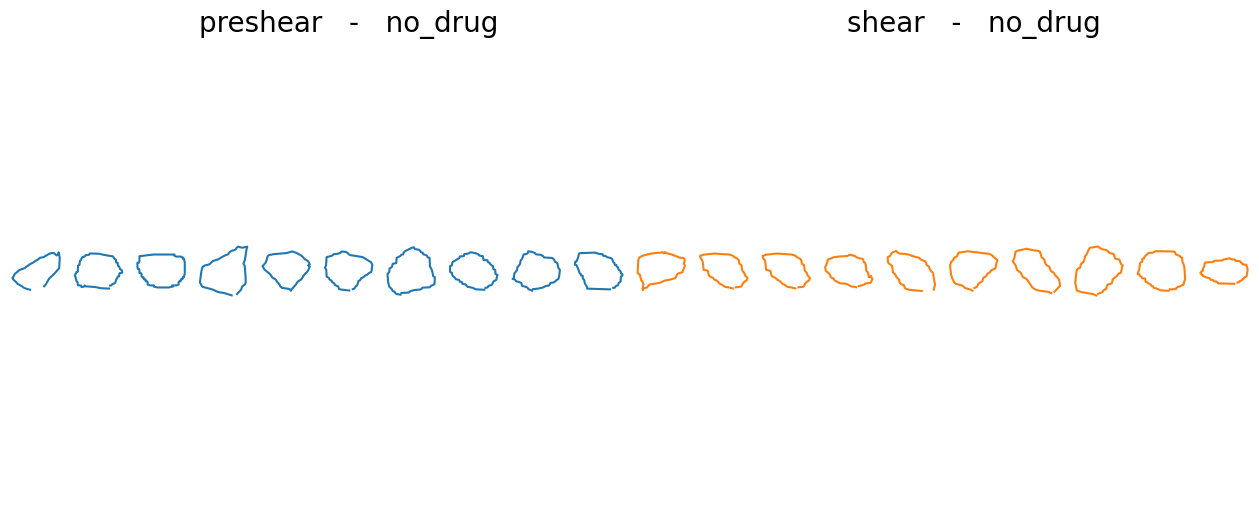

In [76]:
n_cells_to_plot = 10

fig = plt.figure(figsize=(16, 6))
count = 1
for label_b in np.unique(labels_b):
    for i_lab_a, label_a in enumerate(np.unique(labels_a)):
        cell_data = [cell for cell, lab_a, lab_b in zip(cell_shapes, labels_a, labels_b) if lab_a == label_a and lab_b == label_b]
        print(len(cell_data))
        for i_to_plot in range(n_cells_to_plot):
            cell = gs.random.choice(a=cell_data)
            fig.add_subplot(len(np.unique(labels_b)), len(np.unique(labels_a)) * n_cells_to_plot, count)
            count += 1
            plt.plot(cell[:, 0], cell[:, 1], color=f"C{i_lab_a}" )
            plt.axis("equal")
            plt.axis("off")
            if i_to_plot == n_cells_to_plot // 2:
                plt.title(f"{label_a}   -   {label_b}", fontsize=20)
print(len(np.unique(labels_a)))
print(len(np.unique(labels_b)))


100
100


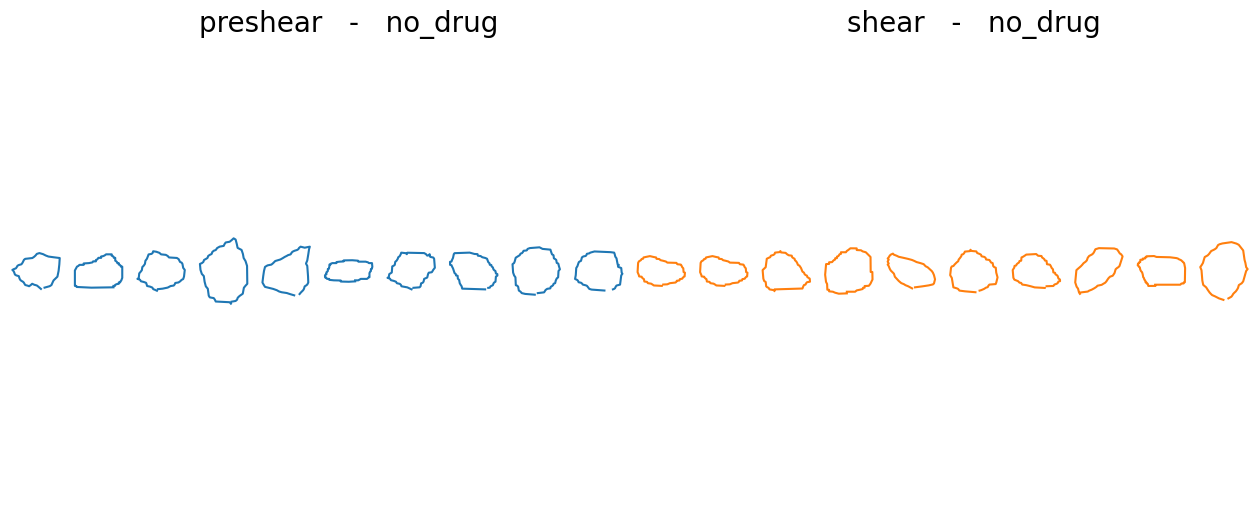

In [77]:
fig = plt.figure(figsize=(16, 6))

count = 1
for label_b in np.unique(labels_b):
    for i_lab_a, label_a in enumerate(np.unique(labels_a)):
        cell_data = [cell for cell, lab_a, lab_b in zip(cell_shapes, labels_a, labels_b) if lab_a == label_a and lab_b == label_b]
        print(len(cell_data))
        # break
        for i_to_plot in range(n_cells_to_plot):
            cell = gs.random.choice(a=cell_data)
            fig.add_subplot(len(np.unique(labels_b)), len(np.unique(labels_a)) * n_cells_to_plot, count)
            count += 1
            plt.plot(cell[:, 0], cell[:, 1], color=f"C{i_lab_a}" )
            plt.axis("equal")
            plt.axis("off")
            if i_to_plot == n_cells_to_plot // 2:
                plt.title(f"{label_a}   -   {label_b}", fontsize=20)
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_sample_cells.svg"))


We observe that generally:
- treated cells are more irregular than control cells,
- dunn cells are more irregular than dlm8 cells.

## Define Shape Spaces

In [78]:
R1 = Euclidean(dim=1)
CLOSED_CURVES_SPACE = ClosedDiscreteCurves(R2)
CURVES_SPACE = DiscreteCurves(R2)
SRV_METRIC = CURVES_SPACE.srv_metric
L2_METRIC = CURVES_SPACE.l2_curves_metric

ELASTIC_METRIC = {}
AS = [1, 2, 0.75, 0.5, 0.25, 0.01] #, 1.6] #, 1.4, 1.2, 1, 0.5, 0.2, 0.1]
BS = [0.5, 1, 0.5, 0.5, 0.5, 0.5] #, 2, 2, 2, 2, 2, 2, 2]
for a, b in zip(AS, BS):
    ELASTIC_METRIC[a, b] = DiscreteCurves(R2, a=a, b=b).elastic_metric
METRICS = {}
METRICS["Linear"] = L2_METRIC
METRICS["SRV"] = SRV_METRIC

# Sample Means

We compare results when computing the mean cell versus the mean cell shapes with different elastic metrics.

In [79]:
means = {}

means["Linear"] = gs.mean(cells, axis=0)
means["SRV"] = FrechetMean(
        metric=SRV_METRIC, 
        method="default").fit(cells).estimate_

In [80]:
for a, b in zip(AS, BS):
    means[a, b] = FrechetMean(
            metric=ELASTIC_METRIC[a, b], 
            method="default").fit(cells).estimate_

We plote the cell shapes corresponding to the means with different metrics.

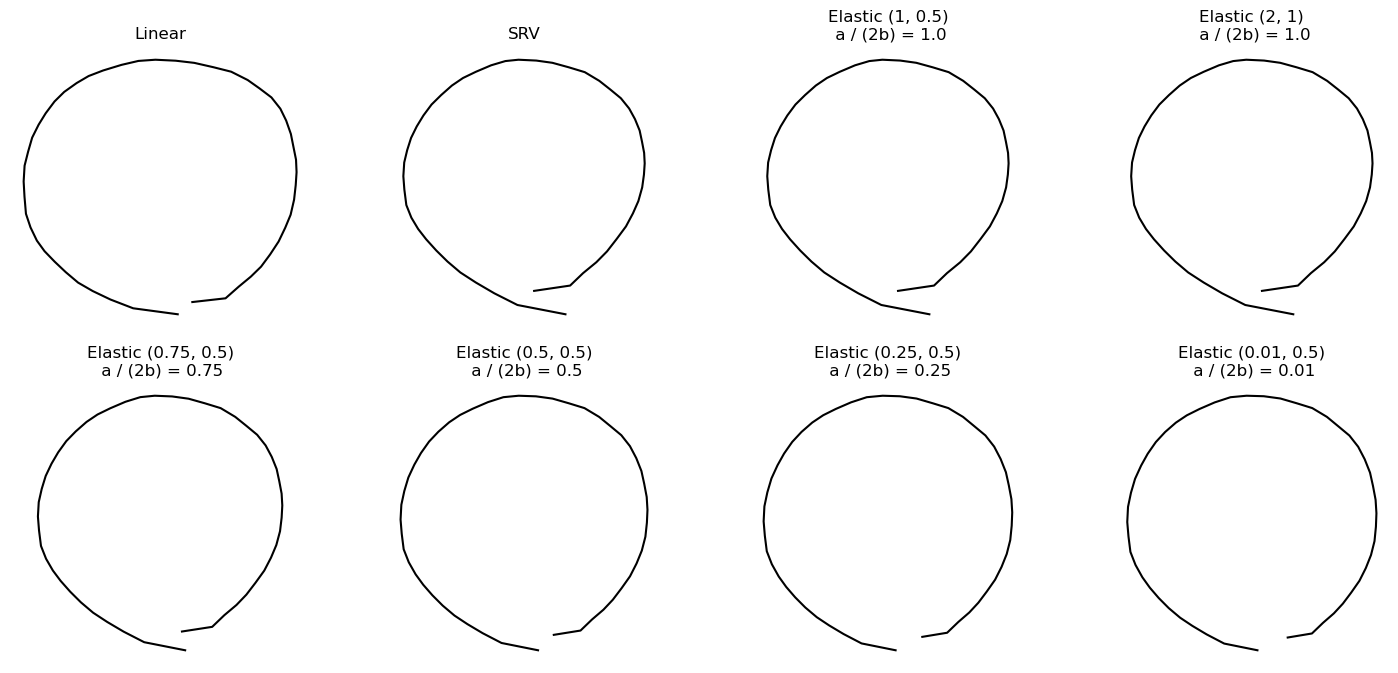

In [81]:
fig = plt.figure(figsize=(18, 8))

ncols = len(means) // 2

for i, (mean_name, mean) in enumerate(means.items()):
    ax = fig.add_subplot(2, ncols, i+1)
    ax.plot(mean[:, 0], mean[:, 1], "black")
    ax.set_aspect("equal")
    ax.axis("off")
    axs_title = mean_name
    if mean_name not in ["Linear", "SRV"]:
        a = mean_name[0]
        b = mean_name[1]
        ratio = a / (2 * b)
        mean_name = f"Elastic {mean_name}\n a / (2b) = {ratio}"
    ax.set_title(mean_name)
    
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_open_means.svg"))

We attempt to plot the closed versions of these means:

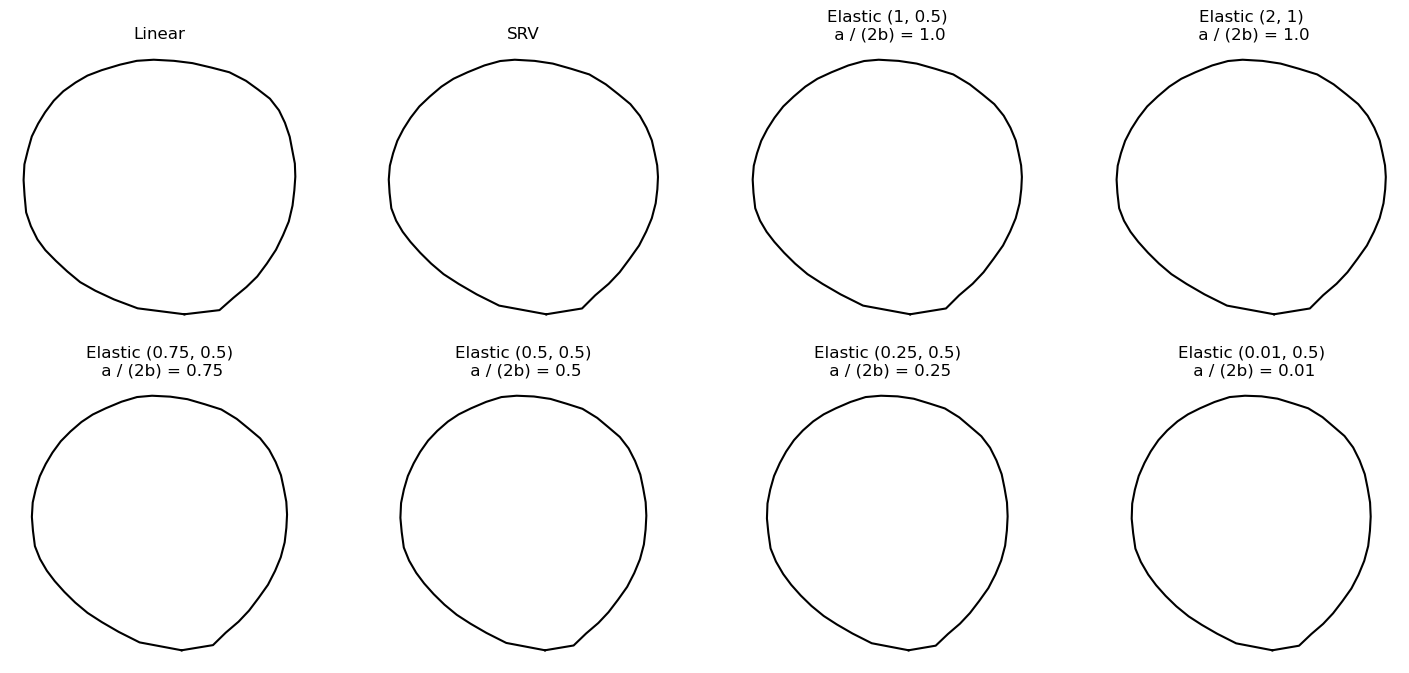

In [82]:
fig = plt.figure(figsize=(18, 8))

ncols = len(means) // 2

for i, (mean_name, mean) in enumerate(means.items()):
    ax = fig.add_subplot(2, ncols, i+1)
    mean = CLOSED_CURVES_SPACE.projection(mean)
    ax.plot(mean[:, 0], mean[:, 1], "black")
    ax.set_aspect("equal")
    ax.axis("off")
    axs_title = mean_name
    if mean_name not in ["Linear", "SRV"]:
        a = mean_name[0]
        b = mean_name[1]
        ratio = a / (2 * b)
        mean_name = f"Elastic {mean_name}\n a / (2b) = {ratio}"
    ax.set_title(mean_name)
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_closed_means.svg"))

**Remark:** Unfortunately, there are some numerical issues with the projection in the space of closed curves, as shown by the V-shaped results above.

Since ratios of 1 give the same results as for the SRV metric, we only select AS, BS with a ratio that is not 1 for the elastic metrics.

We also continue the analysis with the space of open curves, as opposed to the space of closed curves, for the numerical issues observed above.

In [83]:
NEW_AS = [0.75, 0.5, 0.25, 0.01] #, 1.6] #, 1.4, 1.2, 1, 0.5, 0.2, 0.1]
NEW_BS = [0.5, 0.5, 0.5, 0.5] #, 2, 2, 2, 2, 2, 2, 2]

# Distances to the mean(s)

We compute the distances between:
- every cell **shape** in the dataset `cell_shapes`
  - Note: in the version of the notebook from Aug. 4th, we used every cell in the dataset `cells`, i.e. without quotient of scaling and rotation.
- and the mean cell shape, according to the different metrics: Euclidean (Linear), SRV and Elastic Metrics.

In [84]:
# We multiply the distances by a 100, for visualization purposes. It amounts to a change of units.
n_sampling_points = 50

dists = {}

dists["Linear"] = [100 * gs.linalg.norm(means["Linear"] - cell) / n_sampling_points for cell in cells]

dists["SRV"] = [
    100 * SRV_METRIC.dist(means["SRV"], cell) / n_sampling_points for cell in cells
]

for a, b in zip(NEW_AS, NEW_BS):
    dists[a, b] =  [
    100 * ELASTIC_METRIC[a, b].dist(means[a, b], cell) / n_sampling_points for cell in cells
]

In [85]:
print(len(labels_a_name))
print(len(labels_b_name))
print(len(dists))
print(len(dists["Linear"]))
print(len(dists["SRV"]))


5
10
6
200
200


In [86]:
dists_summary = pd.DataFrame(
    data={
        labels_a_name: labels_a,
        labels_b_name: labels_b,
        "Linear": dists["Linear"],
        "SRV": dists["SRV"],
    }
)

for a, b in zip(NEW_AS, NEW_BS):
    dists_summary[f"Elastic({a}, {b})"] = dists[a, b]

In [87]:
dists_summary.head()

,shear,treatments,Linear,SRV,"Elastic(0.75, 0.5)","Elastic(0.5, 0.5)","Elastic(0.25, 0.5)","Elastic(0.01, 0.5)"
0,preshear,no_drug,763.460632,13.296875,11.498712,9.545390,7.876744,7.180298
1,preshear,no_drug,4249.654785,12.395034,10.754253,9.041675,7.627003,7.051556
2,preshear,no_drug,1048.414062,14.052365,12.324515,10.497418,8.990212,8.381380
3,preshear,no_drug,3033.959229,10.550047,8.921968,7.288727,5.957112,5.413134
4,preshear,no_drug,558.259888,14.869467,12.966047,10.795379,8.876169,8.058368


In [88]:
xx = {}

for metric_name in ["Linear", "SRV"]:
    min_dists = gs.array(min(dists_summary[metric_name]))
    max_dists = gs.array(max(dists_summary[metric_name]))
    xx[metric_name] = gs.linspace(gs.floor(min_dists), gs.ceil(max_dists), 100)
    print(min_dists, max_dists)

102.48854064941406 8410.6171875
8.347637629199886 19.37486866217637


In [89]:
def hist_dists_to_means(labels, labels_name, label_color_incr):
    fig, axs = plt.subplots(1, 2, figsize=(18, 4))
    print(labels)
    print(labels_name)

    for i, dist_name in enumerate(["Linear", "SRV"]):
        for i_lab, label in enumerate(np.unique(labels)):
            aux = dists_summary
            display(aux)
            ds = dists_summary[dist_name][dists_summary[labels_name] == label]
            axs[i].hist(
                ds, bins=20, alpha=0.4, density=True, label=label, color=f"C{i_lab+label_color_incr}"
            )
            kde = stats.gaussian_kde(ds)

            axs[i].plot(xx[dist_name], kde(xx[dist_name]), color=f"C{i_lab+label_color_incr}")
        axs[i].legend()
        axs[i].set_title(f"Distances to\n {dist_name} mean\n colored by {labels_name}\n ")


    fig, axs = plt.subplots(1, len(NEW_AS), figsize=(18, 2), sharey=True)

    for i, (a, b) in enumerate(zip(NEW_AS, NEW_BS)):
        for i_lab, label in enumerate(np.unique(labels)):
            ds = dists_summary[f"Elastic({a}, {b})"][dists_summary[labels_name] == label]
            axs[i].hist(
                ds, bins=20, alpha=0.4, density=True, label=label, color=f"C{i_lab+label_color_incr}"
            )
            kde = stats.gaussian_kde(ds)
            axs[i].plot(xx[metric_name], kde(xx[metric_name]), color=f"C{i_lab+label_color_incr}")
        axs[i].legend()
        axs[i].set_title(f"Distances to\n Elastic({a}, {b}) mean\n colored by {labels_name}\n")

['preshear' 'preshear' 'preshear' 'preshear' 'preshear' 'preshear'
 'preshear' 'preshear' 'preshear' 'preshear' 'preshear' 'preshear'
 'preshear' 'preshear' 'preshear' 'preshear' 'preshear' 'preshear'
 'preshear' 'preshear' 'preshear' 'preshear' 'preshear' 'preshear'
 'preshear' 'preshear' 'preshear' 'preshear' 'preshear' 'preshear'
 'preshear' 'preshear' 'preshear' 'preshear' 'preshear' 'preshear'
 'preshear' 'preshear' 'preshear' 'preshear' 'preshear' 'preshear'
 'preshear' 'preshear' 'preshear' 'preshear' 'preshear' 'preshear'
 'preshear' 'preshear' 'preshear' 'preshear' 'preshear' 'preshear'
 'preshear' 'preshear' 'preshear' 'preshear' 'preshear' 'preshear'
 'preshear' 'preshear' 'preshear' 'preshear' 'preshear' 'preshear'
 'preshear' 'preshear' 'preshear' 'preshear' 'preshear' 'preshear'
 'preshear' 'preshear' 'preshear' 'preshear' 'preshear' 'preshear'
 'preshear' 'preshear' 'preshear' 'preshear' 'preshear' 'preshear'
 'preshear' 'preshear' 'preshear' 'preshear' 'preshear' 'presh

,shear,treatments,Linear,SRV,"Elastic(0.75, 0.5)","Elastic(0.5, 0.5)","Elastic(0.25, 0.5)","Elastic(0.01, 0.5)"
0,preshear,no_drug,763.460632,13.296875,11.498712,9.545390,7.876744,7.180298
1,preshear,no_drug,4249.654785,12.395034,10.754253,9.041675,7.627003,7.051556
2,preshear,no_drug,1048.414062,14.052365,12.324515,10.497418,8.990212,8.381380
3,preshear,no_drug,3033.959229,10.550047,8.921968,7.288727,5.957112,5.413134
4,preshear,no_drug,558.259888,14.869467,12.966047,10.795379,8.876169,8.058368
...,...,...,...,...,...,...,...,...
195,shear,no_drug,2559.870361,9.210232,7.526812,5.963008,4.755516,4.274809
196,shear,no_drug,2814.521729,11.551831,9.954232,8.270167,6.842238,6.246741
197,shear,no_drug,3233.749756,12.008712,10.066257,8.199825,6.733107,6.148207
198,shear,no_drug,1385.090576,11.422761,9.590156,7.558242,5.720760,4.895111


,shear,treatments,Linear,SRV,"Elastic(0.75, 0.5)","Elastic(0.5, 0.5)","Elastic(0.25, 0.5)","Elastic(0.01, 0.5)"
0,preshear,no_drug,763.460632,13.296875,11.498712,9.545390,7.876744,7.180298
1,preshear,no_drug,4249.654785,12.395034,10.754253,9.041675,7.627003,7.051556
2,preshear,no_drug,1048.414062,14.052365,12.324515,10.497418,8.990212,8.381380
3,preshear,no_drug,3033.959229,10.550047,8.921968,7.288727,5.957112,5.413134
4,preshear,no_drug,558.259888,14.869467,12.966047,10.795379,8.876169,8.058368
...,...,...,...,...,...,...,...,...
195,shear,no_drug,2559.870361,9.210232,7.526812,5.963008,4.755516,4.274809
196,shear,no_drug,2814.521729,11.551831,9.954232,8.270167,6.842238,6.246741
197,shear,no_drug,3233.749756,12.008712,10.066257,8.199825,6.733107,6.148207
198,shear,no_drug,1385.090576,11.422761,9.590156,7.558242,5.720760,4.895111


,shear,treatments,Linear,SRV,"Elastic(0.75, 0.5)","Elastic(0.5, 0.5)","Elastic(0.25, 0.5)","Elastic(0.01, 0.5)"
0,preshear,no_drug,763.460632,13.296875,11.498712,9.545390,7.876744,7.180298
1,preshear,no_drug,4249.654785,12.395034,10.754253,9.041675,7.627003,7.051556
2,preshear,no_drug,1048.414062,14.052365,12.324515,10.497418,8.990212,8.381380
3,preshear,no_drug,3033.959229,10.550047,8.921968,7.288727,5.957112,5.413134
4,preshear,no_drug,558.259888,14.869467,12.966047,10.795379,8.876169,8.058368
...,...,...,...,...,...,...,...,...
195,shear,no_drug,2559.870361,9.210232,7.526812,5.963008,4.755516,4.274809
196,shear,no_drug,2814.521729,11.551831,9.954232,8.270167,6.842238,6.246741
197,shear,no_drug,3233.749756,12.008712,10.066257,8.199825,6.733107,6.148207
198,shear,no_drug,1385.090576,11.422761,9.590156,7.558242,5.720760,4.895111


,shear,treatments,Linear,SRV,"Elastic(0.75, 0.5)","Elastic(0.5, 0.5)","Elastic(0.25, 0.5)","Elastic(0.01, 0.5)"
0,preshear,no_drug,763.460632,13.296875,11.498712,9.545390,7.876744,7.180298
1,preshear,no_drug,4249.654785,12.395034,10.754253,9.041675,7.627003,7.051556
2,preshear,no_drug,1048.414062,14.052365,12.324515,10.497418,8.990212,8.381380
3,preshear,no_drug,3033.959229,10.550047,8.921968,7.288727,5.957112,5.413134
4,preshear,no_drug,558.259888,14.869467,12.966047,10.795379,8.876169,8.058368
...,...,...,...,...,...,...,...,...
195,shear,no_drug,2559.870361,9.210232,7.526812,5.963008,4.755516,4.274809
196,shear,no_drug,2814.521729,11.551831,9.954232,8.270167,6.842238,6.246741
197,shear,no_drug,3233.749756,12.008712,10.066257,8.199825,6.733107,6.148207
198,shear,no_drug,1385.090576,11.422761,9.590156,7.558242,5.720760,4.895111


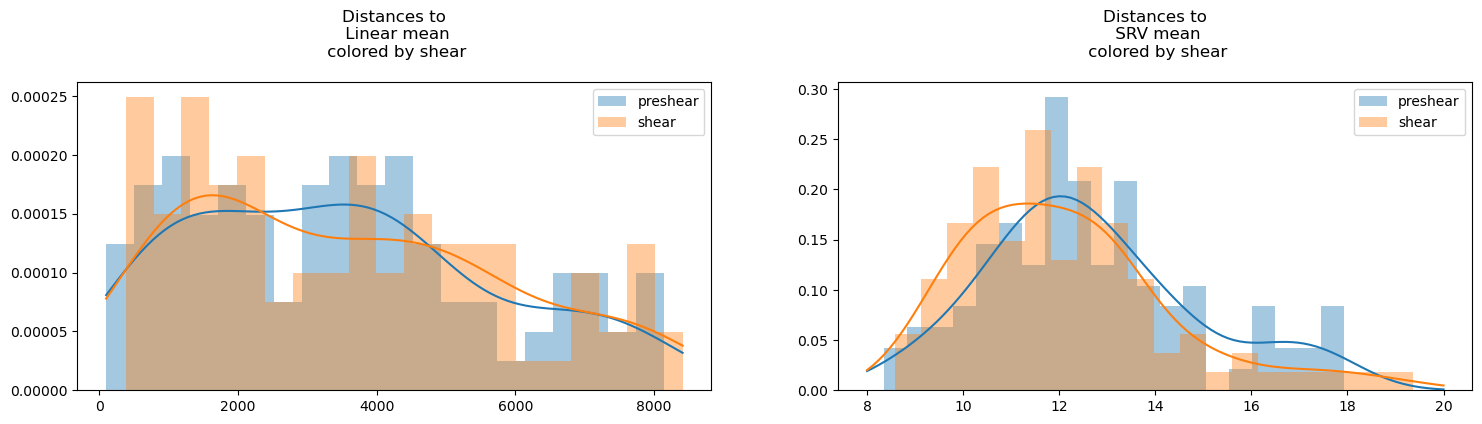

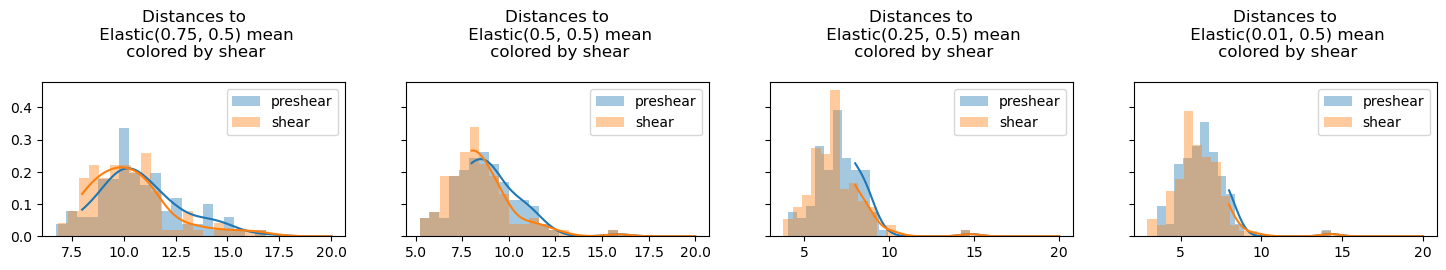

In [90]:
hist_dists_to_means(labels_a, labels_a_name, label_color_incr=0)
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_dist_to_means_by_{labels_a_name}.svg"))

['no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug'
 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug'
 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug'
 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug'
 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug'
 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug'
 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug'
 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug'
 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug'
 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug'
 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug'
 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug'
 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug'
 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug' 'no_drug'
 'no_d

,shear,treatments,Linear,SRV,"Elastic(0.75, 0.5)","Elastic(0.5, 0.5)","Elastic(0.25, 0.5)","Elastic(0.01, 0.5)"
0,preshear,no_drug,763.460632,13.296875,11.498712,9.545390,7.876744,7.180298
1,preshear,no_drug,4249.654785,12.395034,10.754253,9.041675,7.627003,7.051556
2,preshear,no_drug,1048.414062,14.052365,12.324515,10.497418,8.990212,8.381380
3,preshear,no_drug,3033.959229,10.550047,8.921968,7.288727,5.957112,5.413134
4,preshear,no_drug,558.259888,14.869467,12.966047,10.795379,8.876169,8.058368
...,...,...,...,...,...,...,...,...
195,shear,no_drug,2559.870361,9.210232,7.526812,5.963008,4.755516,4.274809
196,shear,no_drug,2814.521729,11.551831,9.954232,8.270167,6.842238,6.246741
197,shear,no_drug,3233.749756,12.008712,10.066257,8.199825,6.733107,6.148207
198,shear,no_drug,1385.090576,11.422761,9.590156,7.558242,5.720760,4.895111


,shear,treatments,Linear,SRV,"Elastic(0.75, 0.5)","Elastic(0.5, 0.5)","Elastic(0.25, 0.5)","Elastic(0.01, 0.5)"
0,preshear,no_drug,763.460632,13.296875,11.498712,9.545390,7.876744,7.180298
1,preshear,no_drug,4249.654785,12.395034,10.754253,9.041675,7.627003,7.051556
2,preshear,no_drug,1048.414062,14.052365,12.324515,10.497418,8.990212,8.381380
3,preshear,no_drug,3033.959229,10.550047,8.921968,7.288727,5.957112,5.413134
4,preshear,no_drug,558.259888,14.869467,12.966047,10.795379,8.876169,8.058368
...,...,...,...,...,...,...,...,...
195,shear,no_drug,2559.870361,9.210232,7.526812,5.963008,4.755516,4.274809
196,shear,no_drug,2814.521729,11.551831,9.954232,8.270167,6.842238,6.246741
197,shear,no_drug,3233.749756,12.008712,10.066257,8.199825,6.733107,6.148207
198,shear,no_drug,1385.090576,11.422761,9.590156,7.558242,5.720760,4.895111


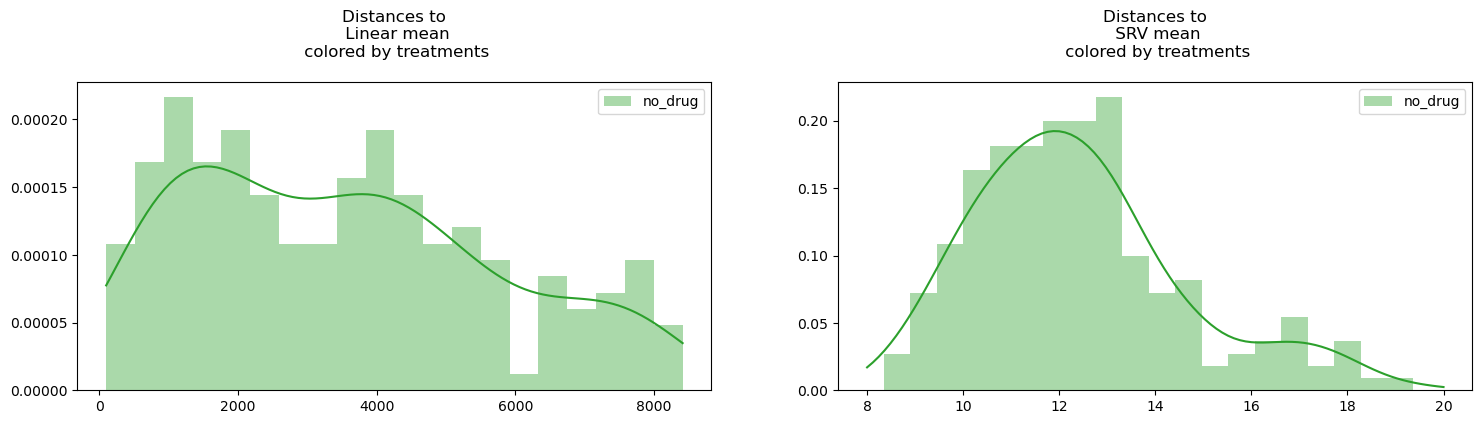

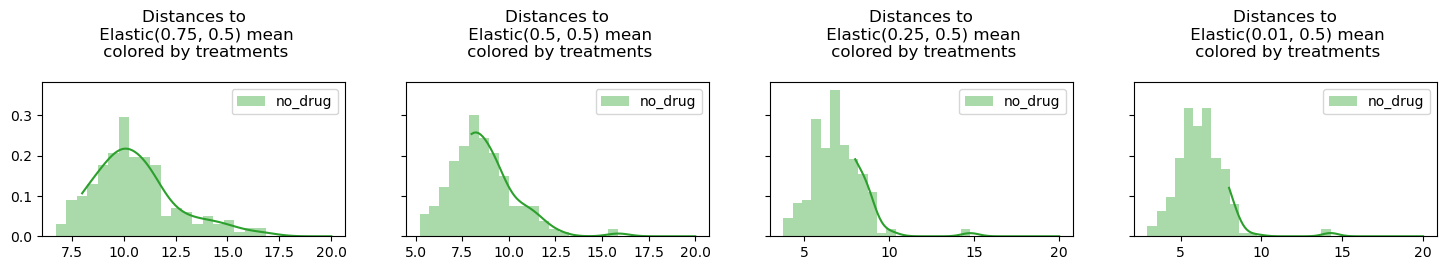

In [91]:
hist_dists_to_means(labels_b, labels_b_name, label_color_incr=2)
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_dist_to_means_by_{labels_b_name}.svg"))

We observe that the histograms of distances vary between the:
- the histogram of distances to the linear mean
- the histogram of distances to the SRV mean.

For example, regarding the histograms colored by cell lines:
- the distributions of distances to the linear mean seem to show that dunn cells are closer to the mean, which is counter-intuitive since they look more irregular,
- the distributions of distances to the srv mean correctly reflec the fact that dunn cells are "further" from the mean.

For example, regarding the histograms colored by treatments:
- the distributions of distances to the linear mean show a peak of the control shapes in the center of the peaks for the cytd and jasp treatments
- while the distributions of distances computed with the SRV metric clearly shows a peak for the control that is closer to the mean shape, and the two peaks of the treatments that are further away.

We also observe that the histogram of jasp (in purple) shows two modes, that correspond to the two lines: this bimodality had not been observed on the histograms of distances to the Linear mean.

However, the histograms of distances to the Elastic means do not seem to bring interesting information.

Thus, for the remainder of this analysis, we focus on the comparison between the Linear mean and the SRV mean.

In [95]:
print(i_lab_a)
print(i_lab_b)

1


NameError: name 'i_lab_b' is not defined

In [97]:
def full_hist_dists_to_means_split():
    for i, dist_name in enumerate(["Linear", "SRV"]):
        fig, axs = plt.subplots(len(np.unique(labels_a)), len(np.unique(labels_b)), figsize=(18, 8))
        for i_lab_a, label_a in enumerate(np.unique(labels_a)):
            for i_lab_b, label_b in enumerate(np.unique(labels_b)):
                ds = dists_summary[dist_name][
                    dists_summary[labels_a_name] == label_a][dists_summary[labels_b_name] == label_b]
                axs[i_lab_a, i_lab_b].hist(
                    ds, bins=20, alpha=0.4, density=True, label=label_a+"-"+label_b, color=f"C{i_lab_a+2*i_lab_b}"
                )
                kde = stats.gaussian_kde(ds)

                axs[i_lab_a, i_lab_b].plot(xx[dist_name], kde(xx[dist_name]), color=f"C{i_lab_a+2*i_lab_b}")
                axs[i_lab_a, i_lab_b].legend()
                axs[i_lab_a, i_lab_b].set_title(f"Distances to {dist_name} mean ")
        plt.tight_layout()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

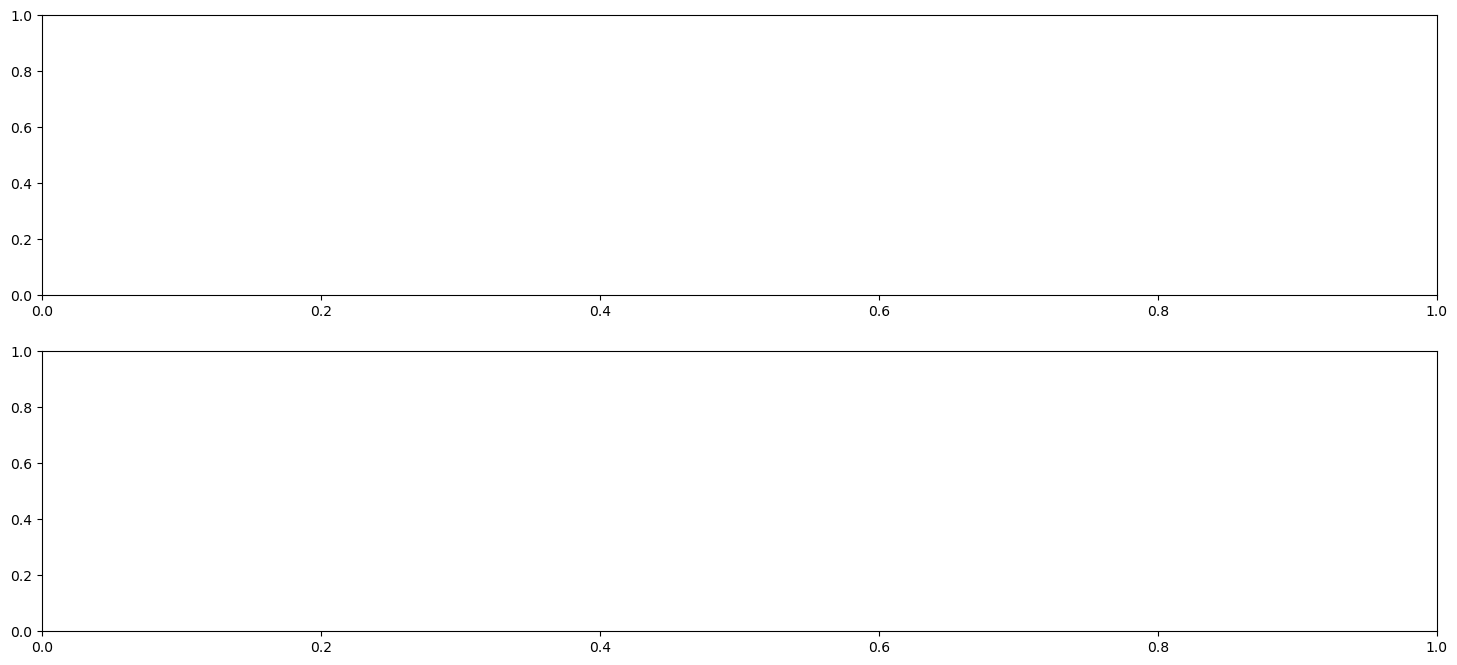

In [98]:
full_hist_dists_to_means_split()
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_dist_to_means_all_split.svg"))

In [99]:
def full_hist_dists_to_means_gather():
    for i, dist_name in enumerate(["Linear", "SRV"]):
        fig, axs = plt.subplots(1, 1, figsize=(12, 6))
        for i_lab_a, label_a in enumerate(np.unique(labels_a)):
            for i_lab_b, label_b in enumerate(np.unique(labels_b)):
                ds = dists_summary[dist_name][
                    dists_summary[labels_a_name] == label_a][dists_summary[labels_b_name] == label_b]
                axs.hist(
                    ds, bins=20, alpha=0.4, density=True, label=label_a+"-"+label_b, color=f"C{i_lab_a+2*i_lab_b}"
                )
                kde = stats.gaussian_kde(ds)

                axs.plot(xx[dist_name], kde(xx[dist_name]), color=f"C{i_lab_a+2*i_lab_b}")
                axs.legend()
                axs.set_title(f"Distances to {dist_name} mean ")
        plt.tight_layout()

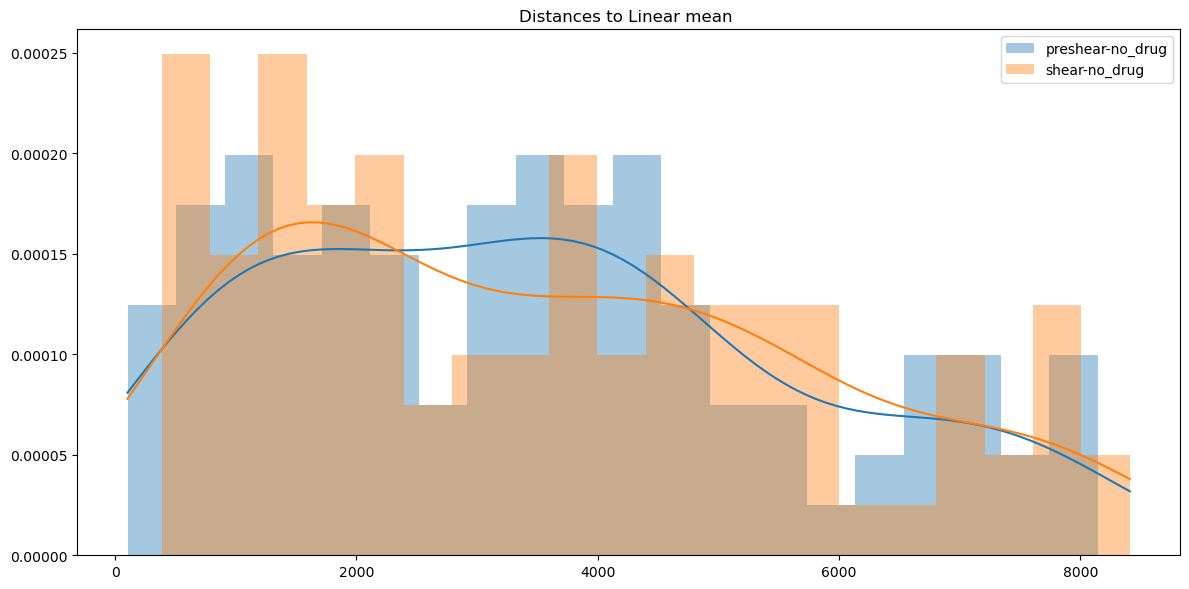

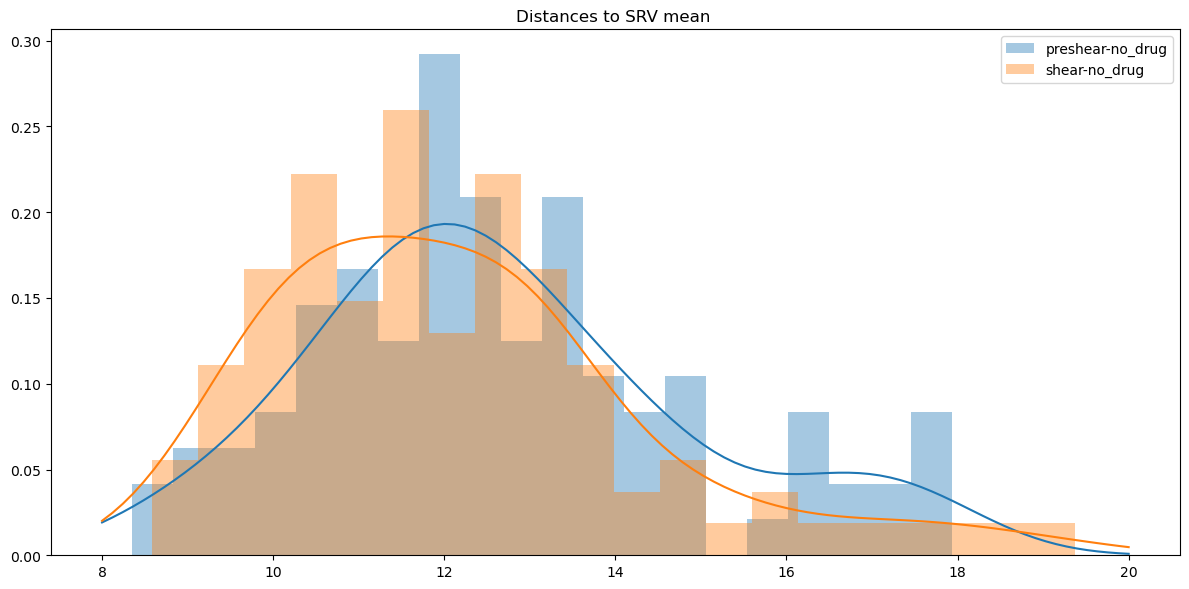

In [100]:
full_hist_dists_to_means_gather()
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_dist_to_means_all_gather.svg"))

# Quantiles of distribution of distances to the mean(s)

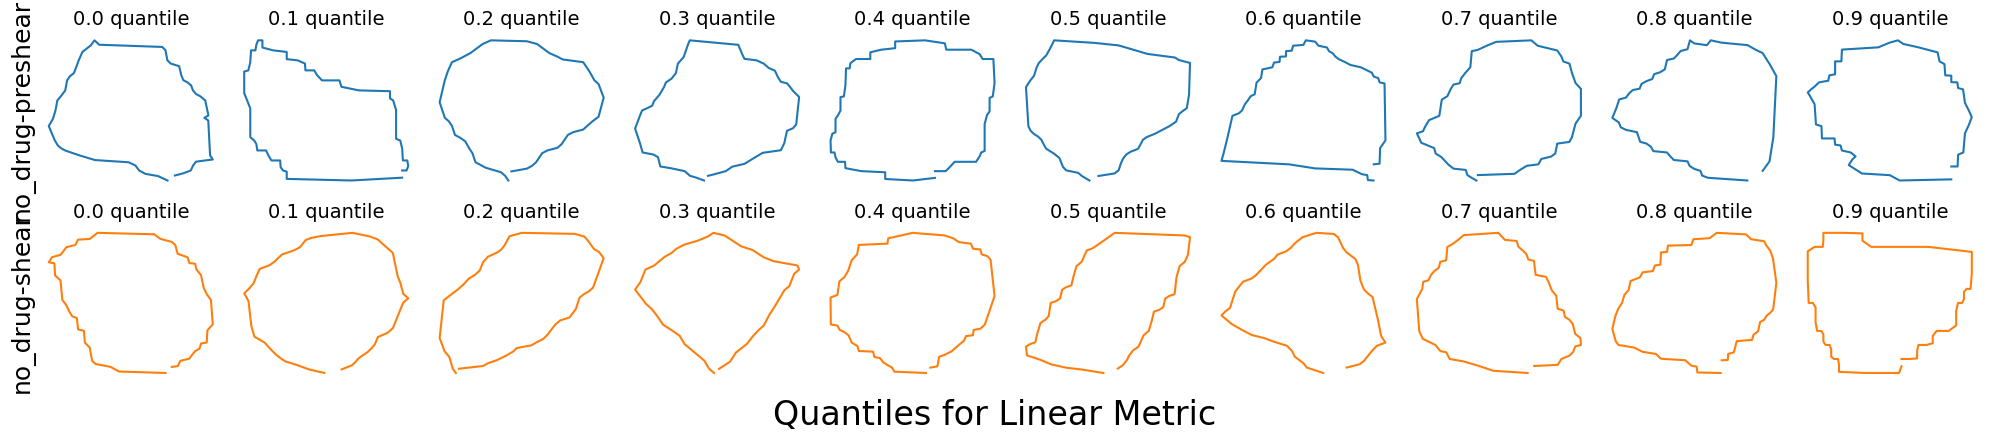

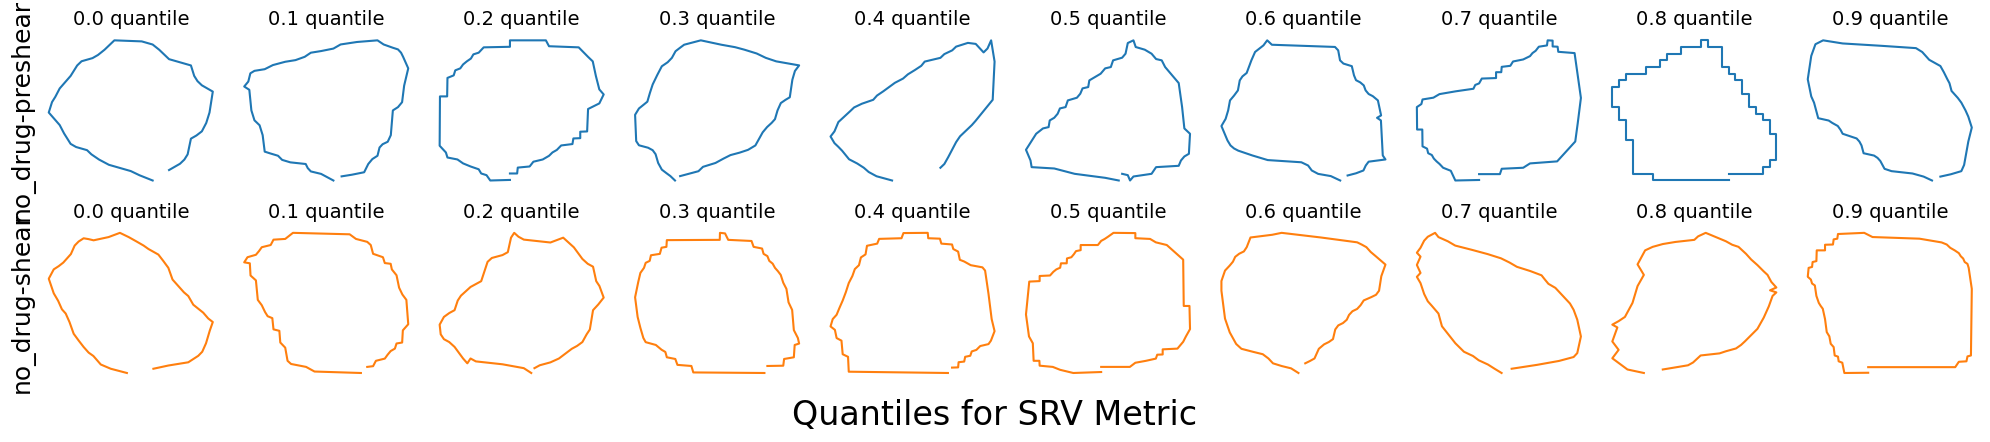

In [101]:
for dist_name in ["Linear", "SRV"]:
    n_quantiles = 10
    fig, axes = plt.subplots(
        nrows=len(labels_b_dict) * len(labels_a_dict),
        ncols=n_quantiles,
        figsize=(20, 2 * len(labels_a_dict) * len(labels_b_dict)),
    )

    for i_lab_b, label_b in enumerate(np.unique(labels_b)):
        for j_lab_a, label_a in enumerate(np.unique(labels_a)):
            dists_list = dists_summary[dist_name][
                        dists_summary[labels_a_name] == label_a][dists_summary[labels_b_name] == label_b]
            # The following line ennsures that all values of distances are different, 
            # which is required in order to use the function "sorted" later
            dists_list = [d + 0.000001 * gs.random.rand(1)[0] for d in dists_list]
            cells_list = [cell for cell, lab_a, lab_b in zip(cell_shapes, labels_a, labels_b) if lab_a == label_a and lab_b == label_b]
            assert len(dists_list) == len(dists_list)
            n_cells = len(dists_list)

            zipped_lists = zip(dists_list, cells_list)
            sorted_pairs = sorted(zipped_lists)

            tuples = zip(*sorted_pairs)
            sorted_dists_list, sorted_cells_list = [list(t) for t in tuples]
            for i_quantile in range(n_quantiles):
                quantile = int(0.1 * n_cells * i_quantile)
                one_cell = sorted_cells_list[quantile]
                ax = axes[2 * i_lab_b + j_lab_a, i_quantile]
                ax.plot(one_cell[:, 0], one_cell[:, 1], c=f"C{j_lab_a}")
                ax.set_title(f"0.{i_quantile} quantile", fontsize=14)
                # Turn off tick labels
                ax.set_yticklabels([])
                ax.set_xticklabels([])
                ax.set_xticks([])
                ax.set_yticks([])
                ax.spines["top"].set_visible(False)
                ax.spines["right"].set_visible(False)
                ax.spines["bottom"].set_visible(False)
                ax.spines["left"].set_visible(False)
                if i_quantile == 0:
                    ax.set_ylabel(f"{label_b}-{label_a}", rotation=90, fontsize=18)
    plt.tight_layout()
    plt.suptitle(f"Quantiles for {dist_name} Metric", y=-0.01, fontsize=24)
    if SAVEFIG:
        plt.savefig(os.path.join(figs_dir, f"{now}_quantiles_{dist_name}.svg"))

# Clustering on distances with KMeans

We investigate whether KMeans performs differently when used with:
- the distances to the linear mean,
- the distances to the SRV mean.

In [102]:
def reorder_confusion_matrix(cmat):
    def _make_cost_m(cm):
        s = np.max(cm)
        return -cm + s

    indexes = linear_assignment(_make_cost_m(cmat))
    js = sorted(indexes, key=lambda x: x[0])[1]
    cm2 = cmat[:, js]
    return cm2

In [104]:
def confusion_kmean(labels, labels_name, labels_dict):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    for i, dist_name in enumerate(["Linear", "SRV"]):
        dists_arr = gs.expand_dims(gs.array(dists_summary[dist_name]), axis=1)
        kmeans = KMeans(n_clusters=len(labels_dict), random_state=0).fit(dists_arr)
        true_labels = [labels_dict[lab] for lab in labels]
        cm = confusion_matrix(true_labels, kmeans.labels_)
        cm = reorder_confusion_matrix(cm)

        axs[i].imshow(cm, interpolation="none", cmap="Blues")
        for (ii, jj), z in np.ndenumerate(cm):
            axs[i].text(jj, ii, z, ha="center", va="center")

        axs[i].axes.xaxis.set_ticks([val for val in labels_dict.values()], [lab for lab in labels_dict])
        axs[i].axes.yaxis.set_ticks([val for val in labels_dict.values()], [lab for lab in labels_dict])
        axs[i].set_xlabel("Kmeans labels")
        axs[i].set_ylabel("True labels")

        acc = 100 * (np.trace(cm) / np.sum(cm))
        axs[i].set_title(
            f"Clustering {labels_name} using \n  distances to {dist_name} mean \n Accuracy: {acc:.2f}%")

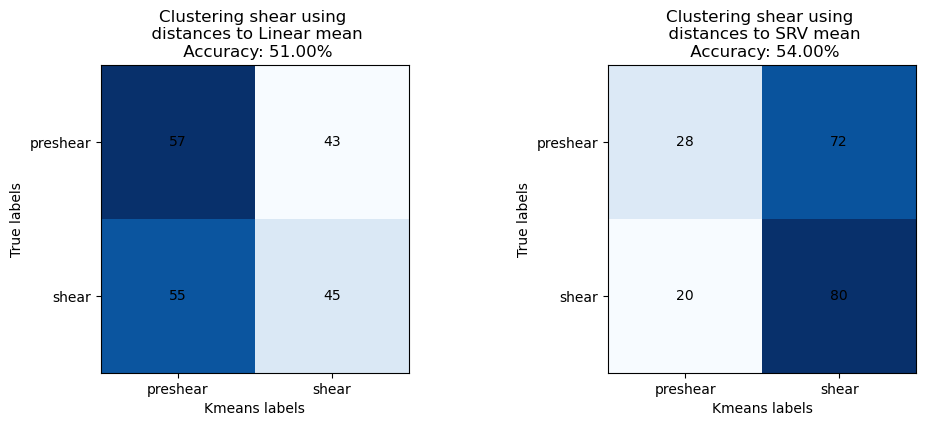

In [105]:
confusion_kmean(labels_a, labels_a_name, labels_a_dict)
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_clustering_by_{labels_a_name}.svg"))

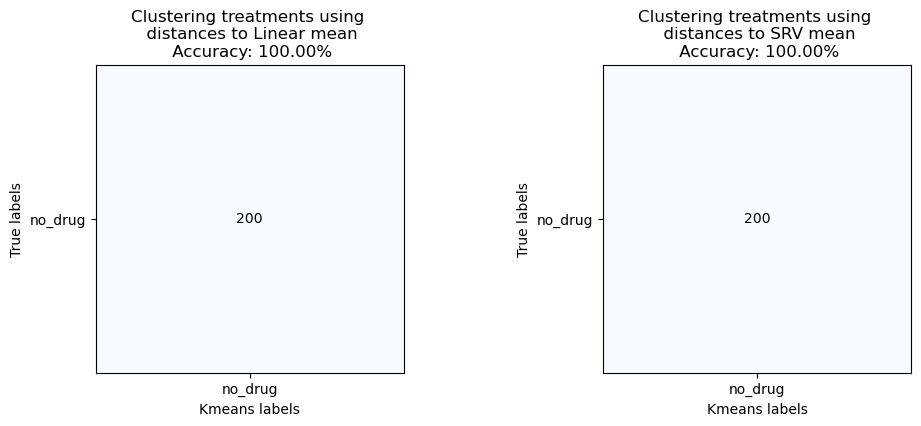

In [106]:
confusion_kmean(labels_b, labels_b_name, labels_b_dict)
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_clustering_by_{labels_b_name}.svg"))

# Classification with Euclidean MDM and Riemannian MDM

In [109]:
def confusion_mdm(labels, labels_name, labels_dict):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    true_labels_ints = [labels_dict[lab] for lab in labels]

    for i, dist_name in enumerate(["Linear", "SRV"]):
        dists_arr = gs.expand_dims(gs.array(dists_summary[dist_name]), axis=1)        
        
        means_of_each_label = []
        for i_lab, lab in enumerate(np.unique(labels)):
            means_of_each_label.append(np.mean(  # mean of scalars in both cases
                dists_summary[dist_name][dists_summary[labels_name] == lab]))
        pred_labels_ints = []  
        for dist_cell in dists_arr:
            distdists = np.array([np.abs(dist_cell - m) for m in means_of_each_label])
            pred_labels_ints.append(np.argmin(distdists))
        
        cm = confusion_matrix(true_labels_ints, pred_labels_ints)
        cm = reorder_confusion_matrix(cm)

        axs[i].imshow(cm, interpolation="none", cmap="Blues")
        for (ii, jj), z in np.ndenumerate(cm):
            axs[i].text(jj, ii, z, ha="center", va="center")

        axs[i].axes.xaxis.set_ticks([val for val in labels_dict.values()], [lab for lab in labels_dict])
        axs[i].axes.yaxis.set_ticks([val for val in labels_dict.values()], [lab for lab in labels_dict])
        axs[i].set_xlabel("MDM labels")
        axs[i].set_ylabel("True labels")

        acc = 100 * (np.trace(cm) / np.sum(cm))
        axs[i].set_title(
            f"Classifying {labels_name} using \n  distances to {dist_name} mean \n Accuracy: {acc:.2f}%")

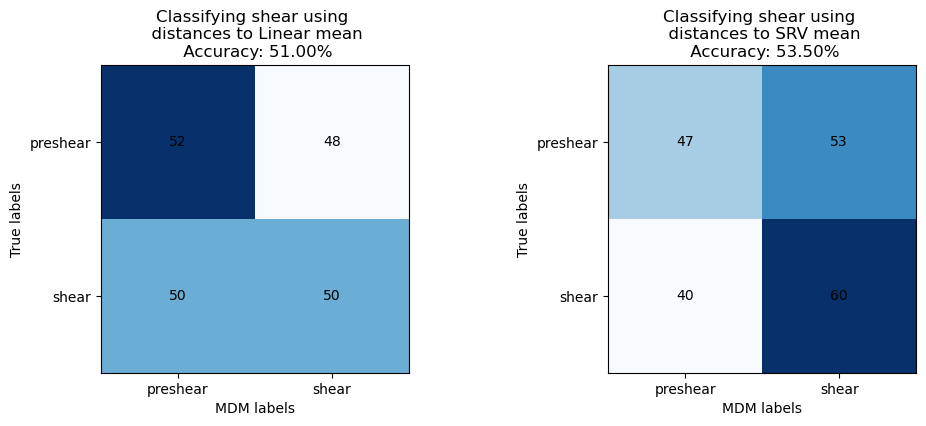

In [110]:
confusion_mdm(labels_a, labels_a_name, labels_a_dict)
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_classification_by_{labels_a_name}.svg"))

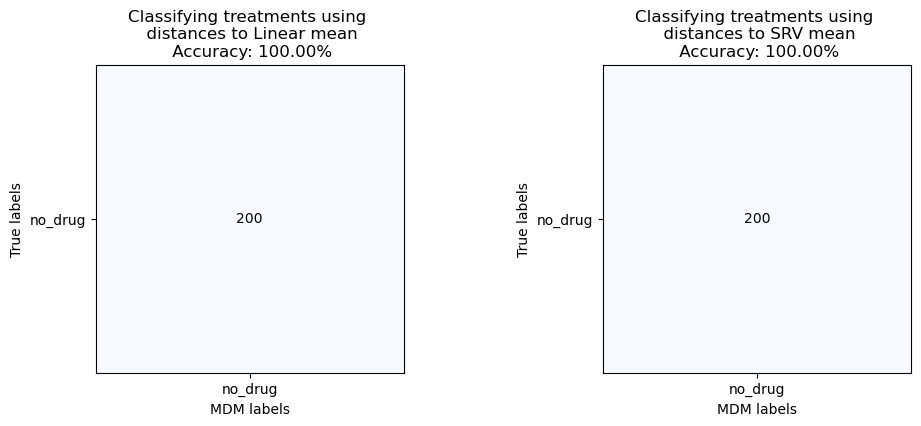

In [111]:
confusion_mdm(labels_b, labels_b_name, labels_b_dict)
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_clustering_by_{labels_b_name}.svg"))

In both the unsupervised and supervised cases, we observe that some controls are clustered/classified as jasp. This makes sense from the histogram of distances, where we see that there is peak in the control distribution beneath the principal mode of the jasp distribution, or a peak in the jasp distribution beneath the principal mode of the control distribution.

# Dimension Reduction with PCA and tPCA

We investigate whether PCA and its Manifold equivalent (tangent PCA) performs differently when used with:
- the Euclidean (linear) metric,
- the SRV metric.

In [112]:
cells_flat = gs.reshape(cells, (len(cells), -1))

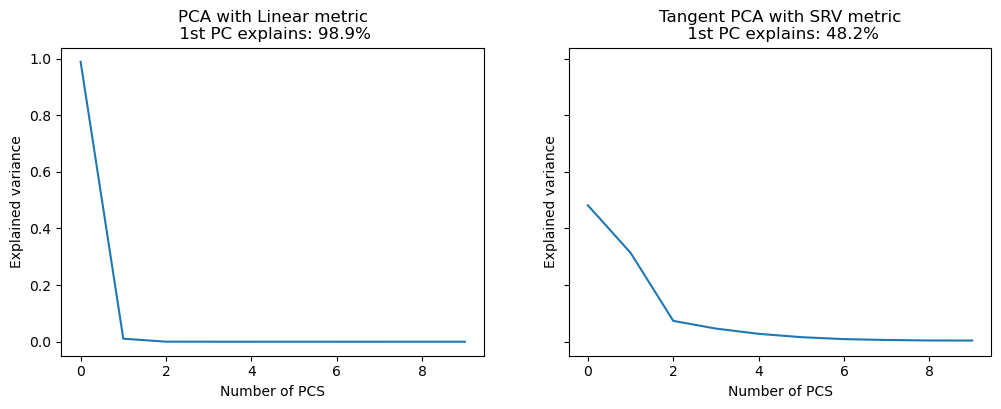

In [113]:
n_components = 10

pcas = {}
pcas["Linear"] = PCA(n_components=n_components).fit(cells_flat)
pcas["SRV"] = TangentPCA(n_components=n_components, metric=SRV_METRIC).fit(cell_shapes)

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

for i, metric_name in enumerate(["Linear", "SRV"]):
    axs[i].plot(pcas[metric_name].explained_variance_ratio_)
    axs[i].set_xlabel("Number of PCS")
    axs[i].set_ylabel("Explained variance")
    tangent = ""
    if metric_name == "SRV":
        tangent = "Tangent "
    first_pc_explains = 100*sum(pcas[metric_name].explained_variance_ratio_[:1])
    axs[i].set_title(f"{tangent}PCA with {metric_name} metric\n 1st PC explains: {first_pc_explains:.1f}%")
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_pca_explained_variance.svg"))

We observe that the first principal components of the tangent PCA using the SRV metric captures a larger portion of the variance.

The first two components of the PCA with the Linear metric captures the following variance ratio:

In [114]:
sum(pcas["Linear"].explained_variance_ratio_[:2])

0.9995497418567538

The first two components of the tangent PCA with the SRV metric captures the following variance ratio:

In [115]:
sum(pcas["SRV"].explained_variance_ratio_[:2])

0.7957208660269279

We explore the projections of the cell data on the two principal components of each PCA.

The projections on the PCA of the SRV metric are more informative, as they have captured more variance.

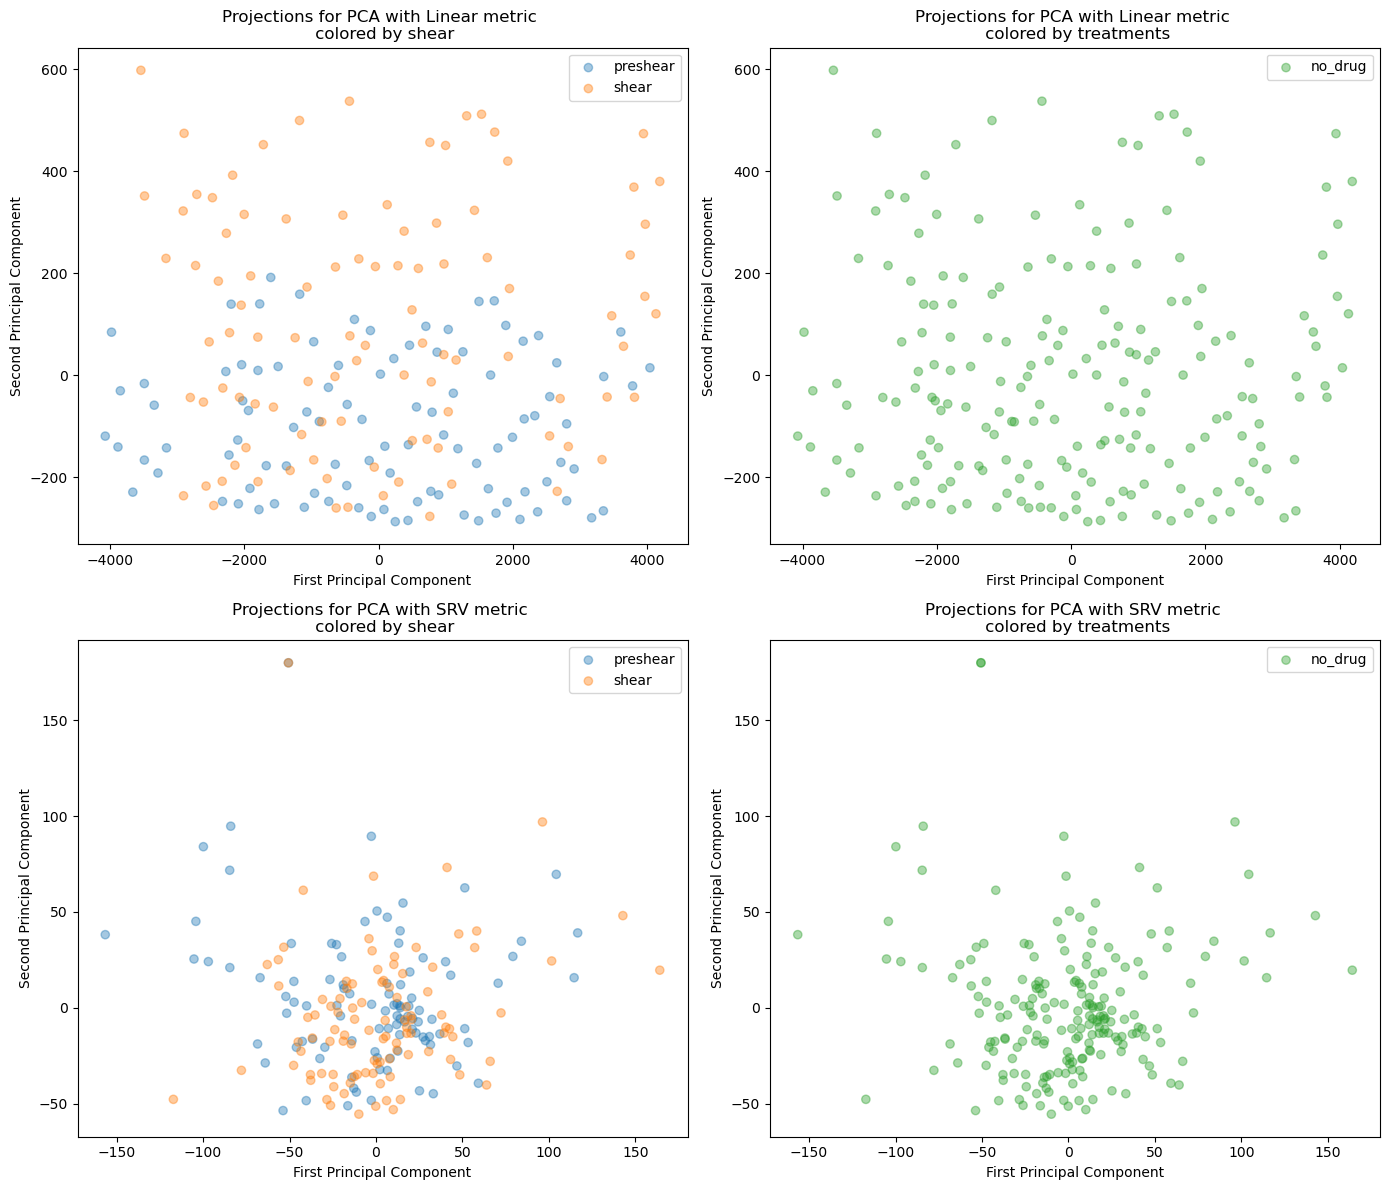

In [116]:
cell_transformed = {}
cell_transformed["Linear"] = pcas["Linear"].fit_transform(cells_flat)
cell_transformed["SRV"] = pcas["SRV"].fit_transform(cell_shapes)

fig, axs = plt.subplots(2, 2, figsize=(14, 12))

for i, metric_name in enumerate(["Linear", "SRV"]):
    for j, (labels_dict, labels, labels_name) in enumerate(zip(
        [labels_a_dict, labels_b_dict], [labels_a, labels_b], [labels_a_name, labels_b_name])):
        for i_lab, label in enumerate(np.unique(labels)):
            cell_tr = cell_transformed[metric_name][dists_summary[labels_name] == label]
            axs[i, j].scatter(
                cell_tr[:, 0],
                cell_tr[:, 1],
                c=[f"C{labels_dict[lab]+2*j}" for lab in labels if lab == label],
                alpha=0.4,
                label=label
            )
            axs[i, j].set_xlabel("First Principal Component")
            axs[i, j].set_ylabel("Second Principal Component")
            axs[i, j].set_title(
                f"Projections for PCA with {metric_name} metric \n colored by {labels_name}")
            axs[i, j].legend()
plt.tight_layout()
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_pca_projections_2d.svg"))

In [117]:
times = np.arange(-0.5, 0.5, 0.1)

def plot_pc(geod, i_pc, metric_name):
    fig = plt.figure(figsize=(8, 1.3))
    for i, curve in enumerate(geod):
        fig.add_subplot(1, len(times), i + 1)
        plt.plot(curve[:, 0], curve[:, 1], c=f"C{i_pc+6}")
        plt.axis("equal")

        plt.axis("off")
        plt.tight_layout()
    fig.suptitle(f"Principal Component {i_pc} for {metric_name} metric")

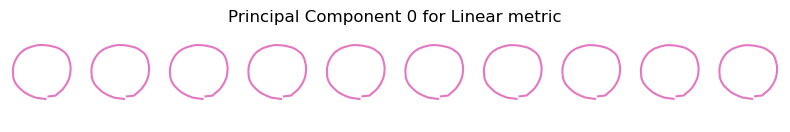

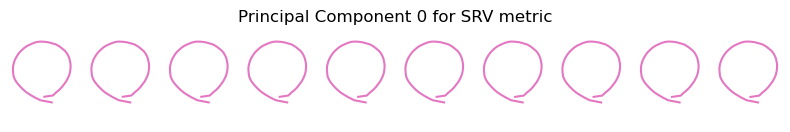

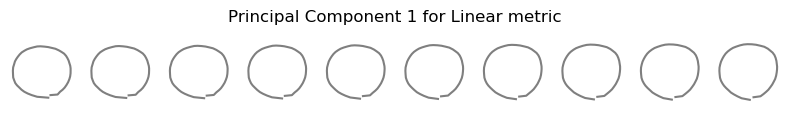

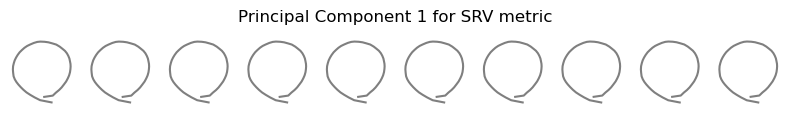

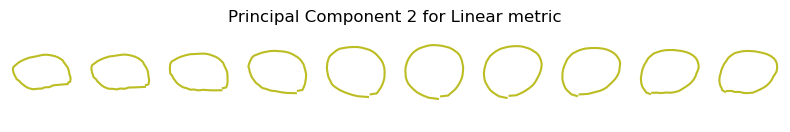

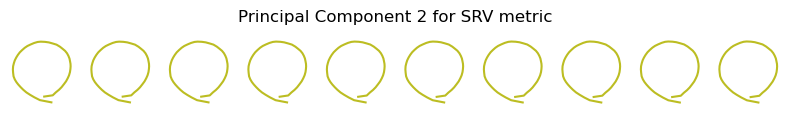

In [118]:
n_pcs = 3

for i_pc in range(n_pcs):
    pc = means["Linear"] + np.einsum(
        "n,ij->nij", 300 * times, pcas["Linear"].components_[i_pc].reshape((n_sampling_points, 2))
    )
    plot_pc(pc, i_pc=i_pc, metric_name="Linear")

    gpc = SRV_METRIC.geodesic(
        initial_point=means["SRV"],
        initial_tangent_vec=pcas["SRV"].components_[i_pc].reshape((n_sampling_points, 2)),
    )(times)

    plot_pc(gpc, i_pc=i_pc, metric_name="SRV")
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_pca_{n_pcs}_pcs.svg"))

# Dimension Reduction via MDS

We examine another dimension reduction technique: Multidimensional Scaling (MDS).

MDS relies on computing the (pairwise) distances between any two pairs of cells, which we do first using just in time compilation (jit) to speed up the computations.

In [119]:
def linear_dist(cell1, cell2):
    return np.linalg.norm(cell1 - cell2) / n_sampling_points

def srv_dist(cell1, cell2):
    return SRV_METRIC.dist(cell1, cell2) / n_sampling_points

In [120]:
@jit(nopython=False, forceobj=True)
def parallel_dist(cells, dist_fun):
    n_cells = len(cells)
    pairwise_dists = np.zeros((n_cells, n_cells))
    for i in prange(n_cells):
        for j in prange(i + 1, n_cells):
            pairwise_dists[i, j] = dist_fun(cells[i], cells[j]) / n_sampling_points
    pairwise_dists += pairwise_dists.T
    return pairwise_dists

Using distance between cell shapes below:

In [121]:
pairwise_dists = parallel_dist(cell_shapes, dist_fun=linear_dist)
pairwise_dists.shape

INFO: finding looplift candidates


(200, 200)

In [122]:
# This takes 7min
pairwise_srv_dists = parallel_dist(cell_shapes, dist_fun=srv_dist)
pairwise_srv_dists.shape

(200, 200)

In [123]:
mds = {}
pos = {}

mds["Linear"] = manifold.MDS(n_components=2, random_state=1, dissimilarity="precomputed")
pos["Linear"] = mds["Linear"].fit(pairwise_dists).embedding_

mds["SRV"] = manifold.MDS(n_components=2, random_state=1, dissimilarity="precomputed")
pos["SRV"] = mds["SRV"].fit(pairwise_srv_dists).embedding_

In [124]:
print(len(pos["Linear"]))
print(len(pos["SRV"]))

200
200


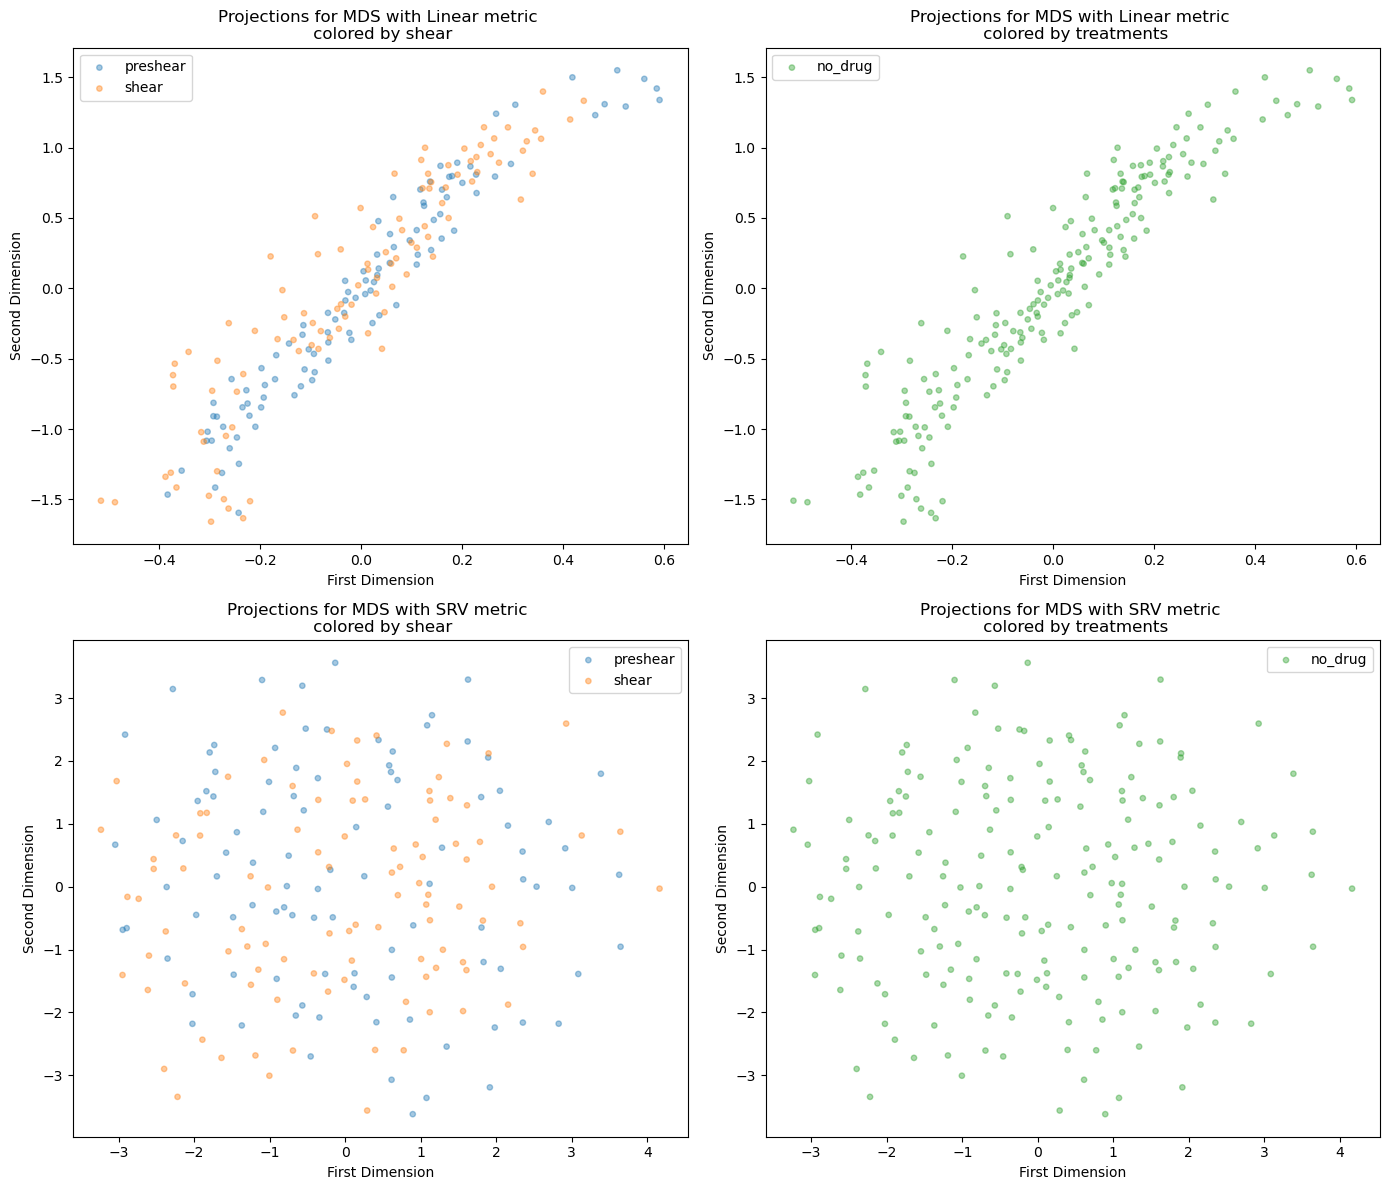

In [125]:
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

for i, metric_name in enumerate(["Linear", "SRV"]):
    for j, (labels_dict, labels, labels_name) in enumerate(zip(
        [labels_a_dict, labels_b_dict], [labels_a, labels_b], [labels_a_name, labels_b_name])):
        for i_lab, label in enumerate(np.unique(labels)):
            position = pos[metric_name][dists_summary[labels_name] == label]
            if metric_name == "SRV":
                position = 1000 * position  # rescaling axis for display purposes
            axs[i, j].scatter(
                position[:, 0],
                position[:, 1],
                c=[f"C{labels_dict[lab]+2*j}" for lab in labels if lab == label],
                alpha=0.4,
                s=15,
                label=label,
            )

            axs[i, j].set_xlabel("First Dimension")
            axs[i, j].set_ylabel("Second Dimension")
            axs[i, j].set_title(
                f"Projections for MDS with {metric_name} metric \n colored by {labels_name}")
            axs[i, j].legend()
plt.tight_layout()
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_mds_projections_2d.svg"))

Interestingly, the MDS with the distances computed from the SRV metric shows a concentric organization of the treatment. The distance to the origin (0, 0) of the space seems related to the treatment.

We sample cell shapes around circles of different radii to explore whether the polar angle contains relevant information.

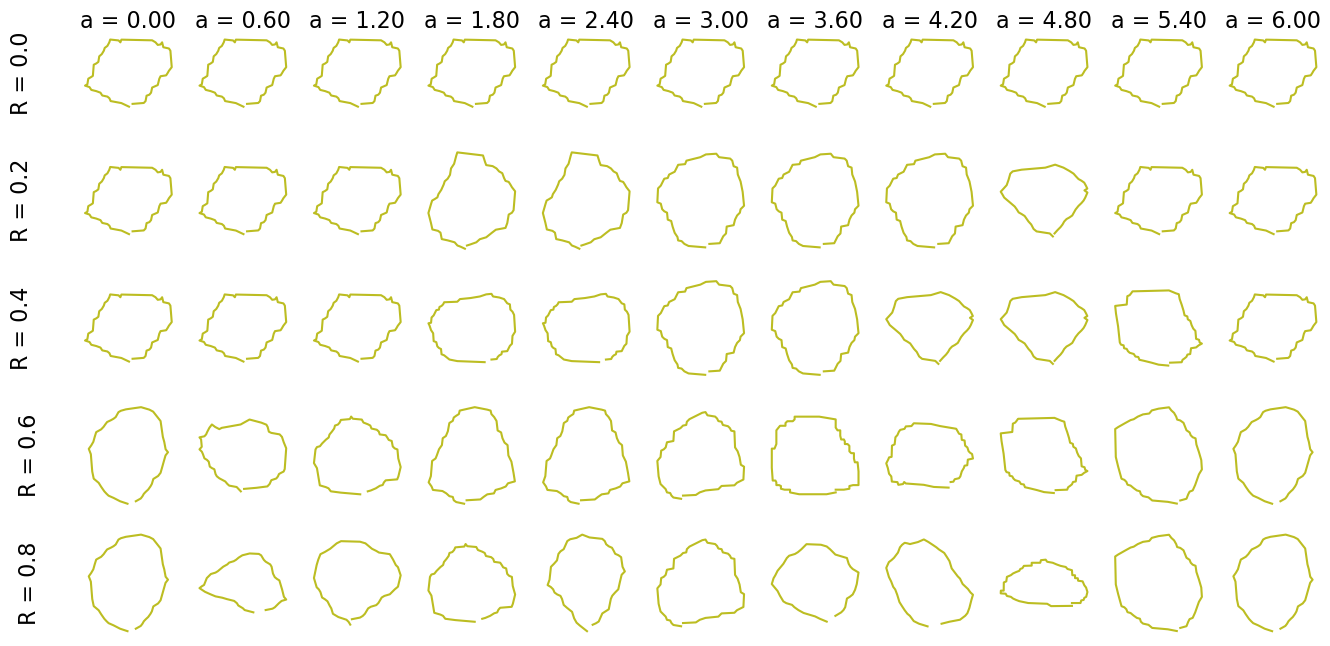

In [126]:
fig = plt.figure(figsize=(16, 8))
thetas = np.arange(0, 2 * np.pi, 0.6)
radii = np.arange(0, 0.001, 0.0002)

left, width = -.5, .5
bottom, height = .25, .5
right = left + width
top = bottom + height

count = 0
for i_radius, radius in enumerate(radii):
    for i_theta, theta in enumerate(thetas):
        ax = fig.add_subplot(len(radii), len(thetas), count + 1)

        pos_theta = np.array([radius * np.cos(theta), radius * np.sin(theta)])
        dists_theta = np.linalg.norm(pos_theta - pos["SRV"], axis=1)
        assert len(dists_theta) == len(cell_shapes)
        idx = np.argmin(dists_theta)

        ax.plot(cells[idx][:, 0], cells[idx][:, 1], c=f"C{i_pc+6}")
        ax.set_aspect("equal")
        ax.get_xaxis().set_visible(False)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_visible(False)
        ax.get_yaxis().set_ticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        if i_radius == 0:
            ax.set_title(f"a = {theta:.2f}", fontsize=16)
        if i_theta == 0:
            ax.text(-0.5, 0.5 * (bottom + top), f"R = {1000 * radius:.1f}", # rescaling for visualization
                horizontalalignment='right',
                verticalalignment='center',
                rotation='vertical',
                transform=ax.transAxes,
                fontsize=16)
        count += 1
    plt.ylabel(f"Radius: {radius}")
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_mds_from_radius_and_angle.svg"))

The following scatter plot shows that the radius in MDS space is the distance to the SRV mean shape.

In [127]:
from scipy.stats import gaussian_kde

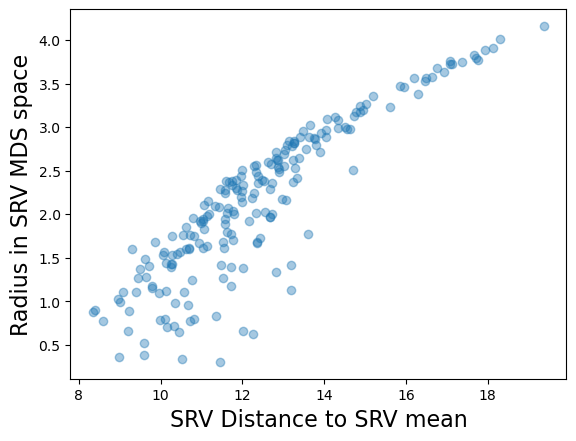

In [128]:
plt.scatter(dists_summary["SRV"], np.linalg.norm(1000 * pos["SRV"], axis=1), alpha=0.4)
plt.xlabel("SRV Distance to SRV mean", fontsize=16)
plt.ylabel("Radius in SRV MDS space", fontsize=16);
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_scatter_mds_radius_and_srv_dist.svg"))

(200, 2)
20230519_09_13_58


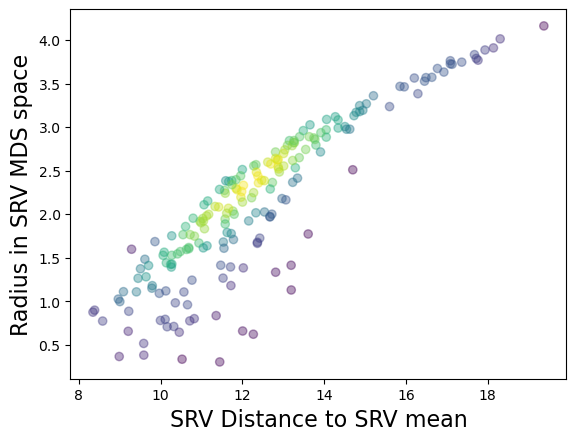

In [129]:
points_to_plot = gs.stack([dists_summary["SRV"], np.linalg.norm(1000 * pos["SRV"], axis=1)], axis=1)
print(points_to_plot.shape)

z = gaussian_kde(points_to_plot.T)(points_to_plot.T)
z_norm = z / z.max()
print(now)
plt.scatter(dists_summary["SRV"], np.linalg.norm(1000 * pos["SRV"], axis=1), alpha=0.4, c=z_norm)
plt.xlabel("SRV Distance to SRV mean", fontsize=16)
plt.ylabel("Radius in SRV MDS space", fontsize=16);
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_density_mds_radius_and_srv_dist.svg"))

# SRV distance and area, perimeter

In [130]:
areas = []
lengths = []
features = []
for cell in cells:
    area = basic.area(cell)
    length = basic.perimeter(cell)
    areas.append(area)
    lengths.append(length)
    features.append(area / length)

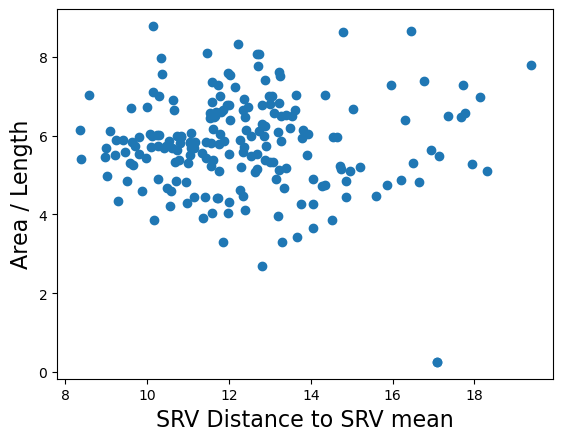

In [131]:
plt.scatter(dists_summary["SRV"], features);
plt.xlabel("SRV Distance to SRV mean", fontsize=16)
plt.ylabel("Area / Length", fontsize=16);
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_scatter_arealength_and_srv_dist.svg"))

(200, 2)


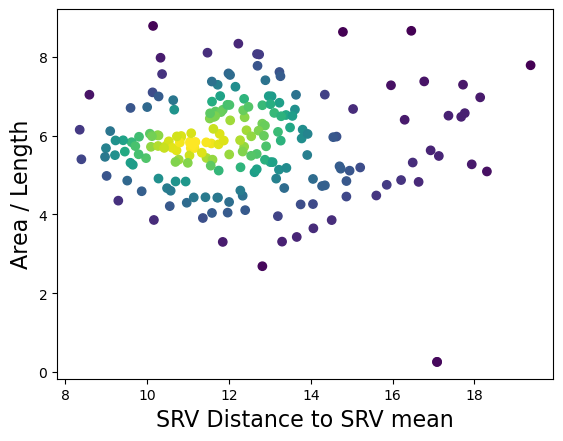

In [132]:
points_to_plot = gs.stack([dists_summary["SRV"], features], axis=1)
print(points_to_plot.shape)

z = gaussian_kde(points_to_plot.T)(points_to_plot.T)
z_norm = z / z.max()

plt.scatter(dists_summary["SRV"], features, c=z_norm);
plt.xlabel("SRV Distance to SRV mean", fontsize=16)
plt.ylabel("Area / Length", fontsize=16);
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_density_arealength_and_srv_dist.svg"))

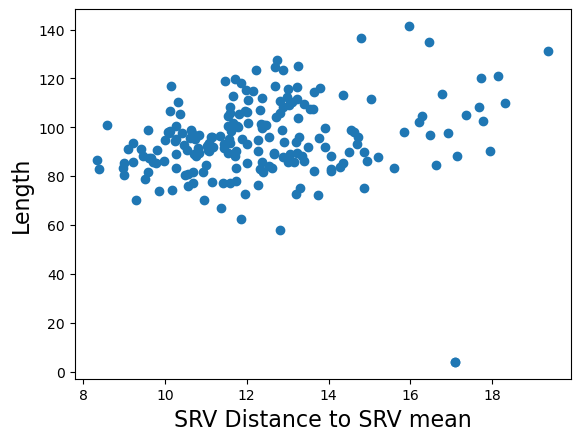

In [133]:
plt.scatter(dists_summary["SRV"], lengths);
plt.xlabel("SRV Distance to SRV mean", fontsize=16)
plt.ylabel("Length", fontsize=16);
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_scatter_length_and_srv_dist.svg"))

(200, 2)


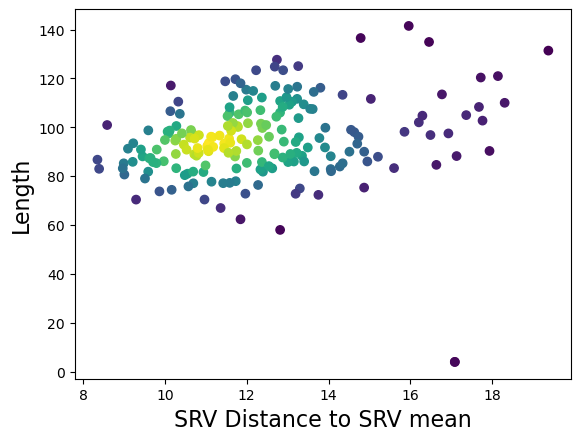

In [134]:
points_to_plot = gs.stack([dists_summary["SRV"], lengths], axis=1)
print(points_to_plot.shape)

z = gaussian_kde(points_to_plot.T)(points_to_plot.T)
z_norm = z / z.max()
plt.scatter(dists_summary["SRV"], lengths, c=z_norm);
plt.xlabel("SRV Distance to SRV mean", fontsize=16)
plt.ylabel("Length", fontsize=16);
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_density_length_and_srv_dist.svg"))

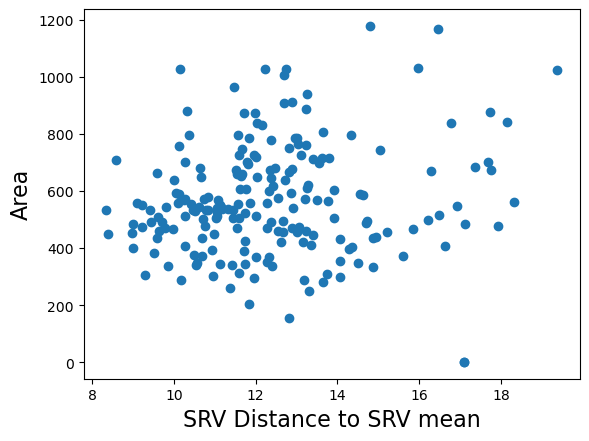

In [135]:
plt.scatter(dists_summary["SRV"], areas);
plt.xlabel("SRV Distance to SRV mean", fontsize=16)
plt.ylabel("Area", fontsize=16);
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_scatter_area_and_srv_dist.svg"))

We observe an almost perfect nonlinear correlation with the lenght of the curve. This is expected since the srv space is a space describing irregularities of the border of the cell, and irregularities are correlated with longer perimeter of a curve, -- for an equivalent area.

However, we note that the SRV space also provides additional degrees of symmetries, such that one can traverse this space, compute geodesics, computes means on a much complex object (the cell shape) than on just the length of the curve.

(200, 2)


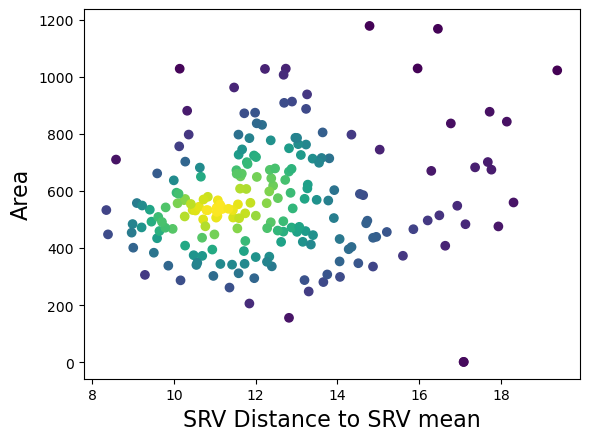

In [136]:
points_to_plot = gs.stack([dists_summary["SRV"], areas], axis=1)
print(points_to_plot.shape)

z = gaussian_kde(points_to_plot.T)(points_to_plot.T)
z_norm = z / z.max()
plt.scatter(dists_summary["SRV"], areas,  c=z_norm);

plt.xlabel("SRV Distance to SRV mean", fontsize=16)
plt.ylabel("Area", fontsize=16);
if SAVEFIG:
    plt.savefig(os.path.join(figs_dir, f"{now}_density_area_and_srv_dist.svg"))

In [139]:
mean = FrechetMean(metric=SRV_METRIC, method="default")
mean.fit(gs.array(cells))

mean_estimate = mean.estimate_

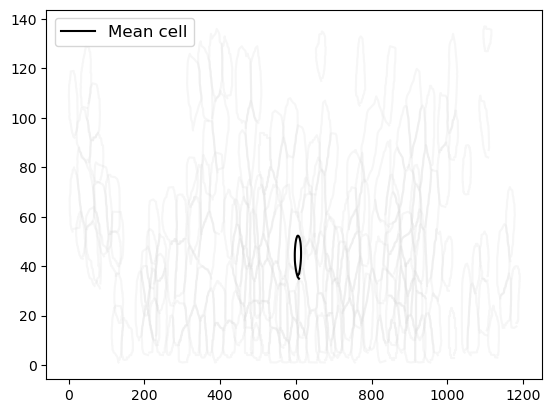

In [140]:
for cell in cells:
    plt.plot(cell[:, 0], cell[:, 1], "lightgrey", alpha=0.2)
    
plt.plot(
    mean_estimate[:, 0], mean_estimate[:, 1], "black", label="Mean cell"
)
plt.legend(fontsize=12);

In [142]:
print(gs.sum(gs.isnan(mean_estimate)))
mean_estimate_clean = mean_estimate[~gs.isnan(gs.sum(mean_estimate, axis=1)), :]
print(mean_estimate_clean.shape)
mean_estimate_clean = plnks.interpolate_dicrete_curve(mean_estimate_clean, 50)
print(gs.sum(gs.isnan(mean_estimate_clean)))
print(mean_estimate_clean.shape)

0
(50, 2)
0
(50, 2)


In [145]:
geodesic = SRV_METRIC.geodesic(initial_point=cells[0], end_point=cells[-1])
n_times = 30
times = gs.linspace(0.0, 1.0, n_times)
geod_points = geodesic(times)

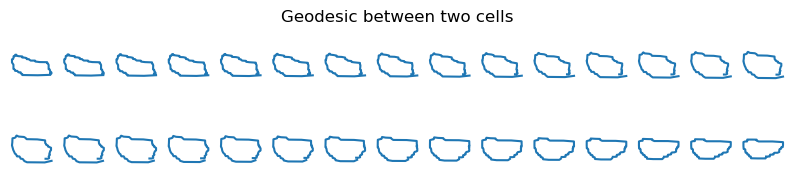

In [146]:
fig = plt.figure(figsize=(10, 2))
plt.title("Geodesic between two cells")
plt.axis("off")

for i, curve in enumerate(geod_points):
    fig.add_subplot(2, n_times // 2, i + 1)
    plt.plot(curve[:, 0], curve[:, 1])
    plt.axis("equal")
    plt.axis("off")
plt.savefig('geotwocells.png')

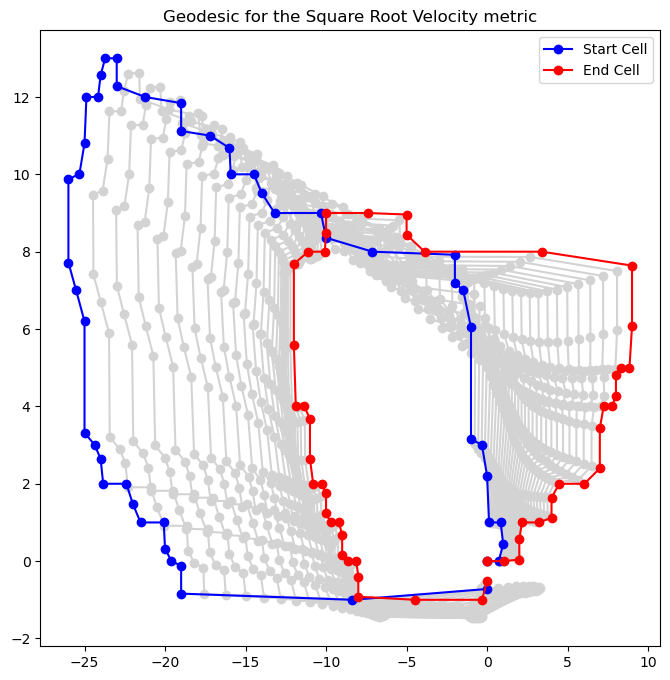

In [147]:
plt.figure(figsize=(8, 8))
for i in range(1, n_times - 1):
    plt.plot(geod_points[i, :, 0], geod_points[i, :, 1], "o-", color="lightgrey")
plt.plot(geod_points[0, :, 0], geod_points[0, :, 1], "o-b", label="Start Cell")
plt.plot(geod_points[-1, :, 0], geod_points[-1, :, 1], "o-r", label="End Cell")

plt.title("Geodesic for the Square Root Velocity metric")
plt.legend()
plt.show()